In [1]:
import numpy as np
import pandas as pd

## LOADING THE DATASETS

In [2]:
# Load the datasets
datasets = {}
file_paths = [
    '2016-2017.csv',
    '2017-2018.csv',
    '2018-2019.csv',
    '2019-2020.csv',
    '2020-2021.csv',
    '2021-2022.csv',
    '2022-2023.csv',
    '2023-2024.csv'
]

for file_path in file_paths:
    # Extracting season name from the file path
    season = file_path.split('/')[-1].split('.')[0]
    datasets[season] = pd.read_csv(file_path)


In [3]:
# Display the keys (seasons) to confirm loading
print(datasets.keys())

dict_keys(['2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024'])


In [4]:
# Checking the columns (features) in each dataset
features = {season: data.columns.tolist() for season, data in datasets.items()}
print(features)

{'2016-2017': ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA'], '2017-2018': ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', '

## FEATURE ENGINEERING

In [5]:
# Define the function to calculate points based on match result
def calculate_points(row):
    if row['FTR'] == 'H':
        return 3, 0
    elif row['FTR'] == 'A':
        return 0, 3
    else:
        return 1, 1

In [6]:
# Apply this function to each dataset and create new columns
for season in datasets:
    datasets[season][['HomePoints', 'AwayPoints']] = datasets[season].apply(calculate_points, axis=1, result_type='expand')


In [7]:
# Define the function to parse the date and extract the year
def parse_date(date_str):
    for fmt in ('%d/%m/%Y', '%d/%m/%y'):
        try:
            return pd.to_datetime(date_str, format=fmt).year
        except ValueError:
            pass
    return None

# Apply this function to each dataset to create a new column 'Year'
for season in datasets:
    datasets[season]['Year'] = datasets[season]['Date'].apply(parse_date)


In [8]:
# Create home features for each dataset
home_features = {}

for season, df in datasets.items():
    # Calculate the 'Season' column
    df['Season'] = df['Date'].apply(parse_date)
    
    # Group by 'HomeTeam' and aggregate the required statistics
    home_stats = df.groupby('HomeTeam').agg(
        Season=('Season', 'first'),
        Points=('HomePoints', 'sum'),
        GoalsScored=('FTHG', 'sum'),
        GoalsConceded=('FTAG', 'sum'),
        Wins=('HomePoints', lambda x: (x == 3).sum()),
        Draws=('HomePoints', lambda x: (x == 1).sum()),
        Losses=('HomePoints', lambda x: (x == 0).sum())
    ).reset_index().rename(columns={'HomeTeam': 'Team'})
    
    # Store the results in a dictionary with the season as the key
    home_features[season] = home_stats

In [9]:
# Create away features for each dataset
away_features = {}

for season, df in datasets.items():
    # Group by 'AwayTeam' and aggregate the required statistics
    away_stats = df.groupby('AwayTeam').agg(
        Season=('Season', 'first'),
        Points=('AwayPoints', 'sum'),
        GoalsScored=('FTAG', 'sum'),
        GoalsConceded=('FTHG', 'sum'),
        Wins=('AwayPoints', lambda x: (x == 3).sum()),
        Draws=('AwayPoints', lambda x: (x == 1).sum()),
        Losses=('AwayPoints', lambda x: (x == 0).sum())
    ).reset_index().rename(columns={'AwayTeam': 'Team'})
    
    # Store the results in a dictionary with the season as the key
    away_features[season] = away_stats

In [10]:
# Combine home and away statistics for each season
combined_features = {}

for season in home_features:
    # Merge home and away statistics on the team and season
    combined_stats = pd.merge(
        home_features[season],
        away_features[season],
        on=['Team', 'Season'],
        suffixes=('_Home', '_Away')
    )
    
    # Calculate additional combined statistics
    combined_stats['TotalPoints'] = combined_stats['Points_Home'] + combined_stats['Points_Away']
    combined_stats['TotalGoalsScored'] = combined_stats['GoalsScored_Home'] + combined_stats['GoalsScored_Away']
    combined_stats['TotalGoalsConceded'] = combined_stats['GoalsConceded_Home'] + combined_stats['GoalsConceded_Away']
    combined_stats['TotalWins'] = combined_stats['Wins_Home'] + combined_stats['Wins_Away']
    combined_stats['TotalDraws'] = combined_stats['Draws_Home'] + combined_stats['Draws_Away']
    combined_stats['TotalLosses'] = combined_stats['Losses_Home'] + combined_stats['Losses_Away']
    
    # Store the combined statistics in a dictionary with the season as the key
    combined_features[season] = combined_stats

In [11]:
print(combined_stats.head())

          Team  Season  Points_Home  GoalsScored_Home  GoalsConceded_Home  \
0      Arsenal    2023           47                48                  16   
1  Aston Villa    2023           40                48                  28   
2  Bournemouth    2023           27                27                  28   
3    Brentford    2023           22                29                  34   
4     Brighton    2023           30                30                  27   

   Wins_Home  Draws_Home  Losses_Home  Points_Away  GoalsScored_Away  \
0         15           2            2           42                43   
1         12           4            3           28                28   
2          7           6            6           21                27   
3          5           7            7           17                27   
4          8           6            5           18                25   

   GoalsConceded_Away  Wins_Away  Draws_Away  Losses_Away  TotalPoints  \
0                  13         

In [12]:
# Create a summary for all seasons
summary = []

for season, stats in combined_features.items():
    summary.append({
        'Season': season,
        'TotalTeams': stats['Team'].nunique(),
        'AveragePoints': stats['TotalPoints'].mean(),
        'AverageGoalsScored': stats['TotalGoalsScored'].mean(),
        'AverageGoalsConceded': stats['TotalGoalsConceded'].mean(),
        'TotalGoalsScored': stats['TotalGoalsScored'].sum(),
        'TotalGoalsConceded': stats['TotalGoalsConceded'].sum(),
        'TotalWins': stats['TotalWins'].sum(),
        'TotalDraws': stats['TotalDraws'].sum(),
        'TotalLosses': stats['TotalLosses'].sum(),
    })

# Convert the summary list into a DataFrame for better readability
summary_df = pd.DataFrame(summary)

In [13]:
print(summary_df)

      Season  TotalTeams  AveragePoints  AverageGoalsScored  \
0  2016-2017          20          52.80               53.20   
1  2017-2018          20          52.05               50.90   
2  2018-2019          20          53.45               53.60   
3  2019-2020          20          52.40               51.70   
4  2020-2021          20          52.85               51.20   
5  2021-2022          20          52.60               53.55   
6  2022-2023          20          52.65               54.20   
7  2023-2024          20          52.90               62.30   

   AverageGoalsConceded  TotalGoalsScored  TotalGoalsConceded  TotalWins  \
0                 53.20              1064                1064        296   
1                 50.90              1018                1018        281   
2                 53.60              1072                1072        309   
3                 51.70              1034                1034        288   
4                 51.20              1024           

In [14]:
# Combine all seasons into a single DataFrame
seasons_combined = pd.concat(combined_features.values(), ignore_index=True)

In [15]:
print(seasons_combined)

                 Team  Season  Points_Home  GoalsScored_Home  \
0             Arsenal    2016           45                39   
1         Bournemouth    2016           31                35   
2             Burnley    2016           33                26   
3             Chelsea    2016           51                55   
4      Crystal Palace    2016           20                24   
..                ...     ...          ...               ...   
155     Nott'm Forest    2023           20                27   
156  Sheffield United    2023           10                19   
157         Tottenham    2023           39                38   
158          West Ham    2023           29                31   
159            Wolves    2023           27                26   

     GoalsConceded_Home  Wins_Home  Draws_Home  Losses_Home  Points_Away  \
0                    16         14           3            2           30   
1                    29          9           4            6           15   
2  

In [16]:
# Create the 'Champion' column indicating the team with the maximum points in each season
seasons_combined['Champion'] = seasons_combined.groupby('Season')['TotalPoints'].transform(lambda x: x == x.max()).astype(int)

# Display the first few rows to confirm the 'Champion' column has been added
print(seasons_combined.head())

             Team  Season  Points_Home  GoalsScored_Home  GoalsConceded_Home  \
0         Arsenal    2016           45                39                  16   
1     Bournemouth    2016           31                35                  29   
2         Burnley    2016           33                26                  20   
3         Chelsea    2016           51                55                  17   
4  Crystal Palace    2016           20                24                  25   

   Wins_Home  Draws_Home  Losses_Home  Points_Away  GoalsScored_Away  ...  \
0         14           3            2           30                38  ...   
1          9           4            6           15                20  ...   
2         10           3            6            7                13  ...   
3         17           0            2           42                30  ...   
4          6           2           11           21                26  ...   

   Wins_Away  Draws_Away  Losses_Away  TotalPoints  Tota

## EXPLORATORY DATA ANALYSIS

In [17]:
# Summary statistics for the numerical features in the dataset
summary_stats = seasons_combined.describe()

In [18]:
print(summary_stats)

            Season  Points_Home  GoalsScored_Home  GoalsConceded_Home  \
count   160.000000   160.000000        160.000000          160.000000   
mean   2019.500000    30.143750         29.718750           24.112500   
std       2.298482    10.272909         11.091485            7.663511   
min    2016.000000     8.000000          9.000000            9.000000   
25%    2017.750000    23.000000         21.750000           18.000000   
50%    2019.500000    28.500000         27.000000           24.000000   
75%    2021.250000    37.000000         36.000000           28.000000   
max    2023.000000    55.000000         61.000000           57.000000   

       Wins_Home  Draws_Home  Losses_Home  Points_Away  GoalsScored_Away  \
count  160.00000  160.000000   160.000000   160.000000        160.000000   
mean     8.61875    4.287500     6.093750    22.568750         24.112500   
std      3.67701    1.956725     3.269445     9.973942          8.800363   
min      2.00000    0.000000     0.000

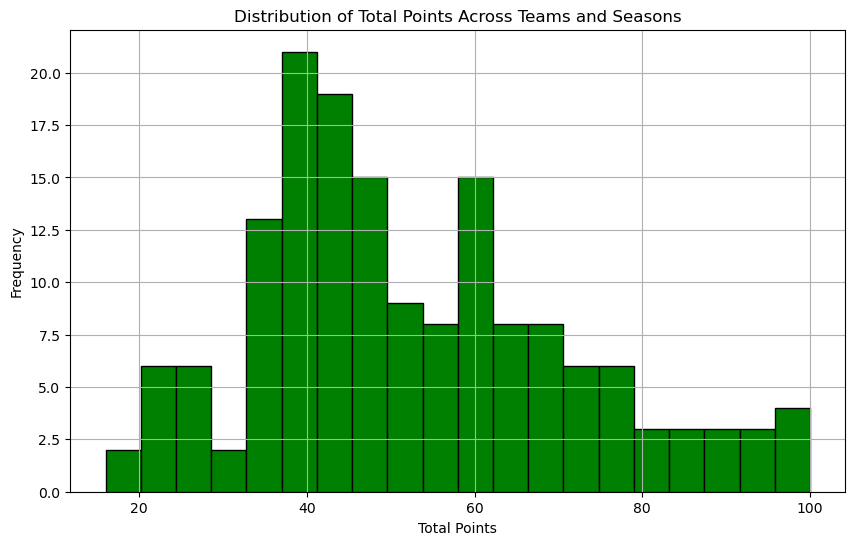

In [19]:
import matplotlib.pyplot as plt

# Plot the distribution of total points across all seasons
plt.figure(figsize=(10, 6))
plt.hist(seasons_combined['TotalPoints'], bins=20, color='green', edgecolor='black')
plt.title('Distribution of Total Points Across Teams and Seasons')
plt.xlabel('Total Points')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


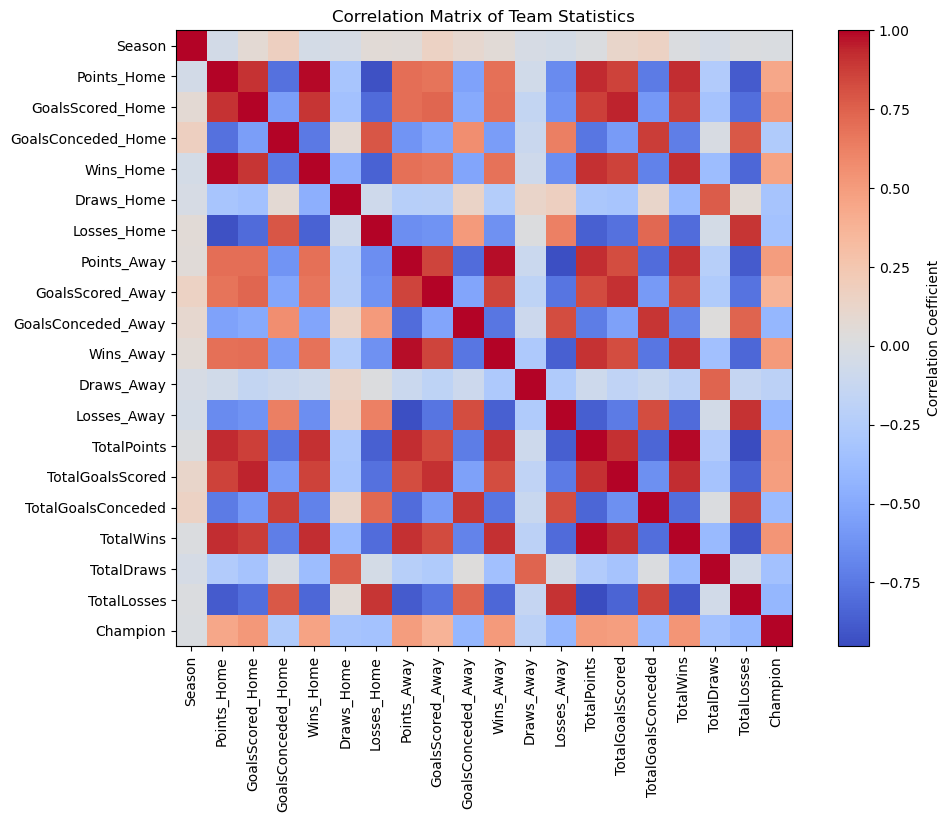

In [20]:
# Select only the numeric columns for correlation analysis
numeric_columns = seasons_combined.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix for numeric columns only
correlation_matrix = numeric_columns.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix of Team Statistics')
plt.show()

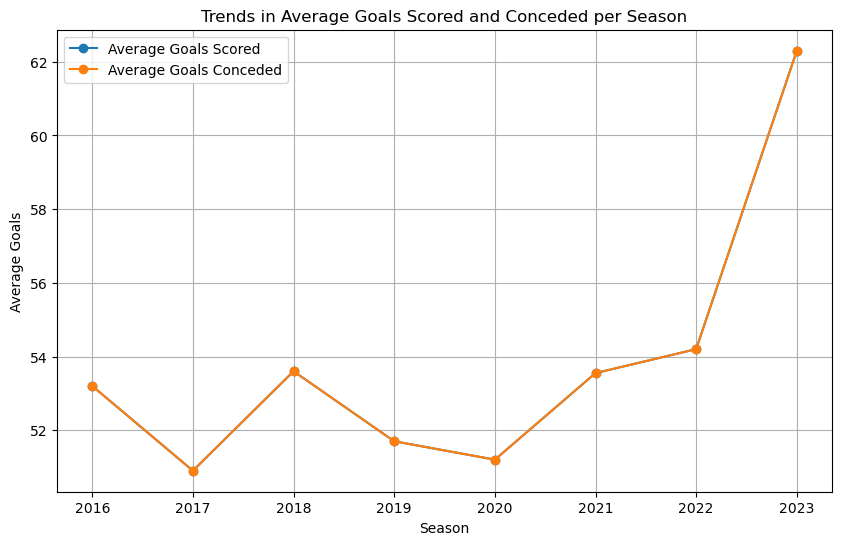

In [21]:
# Analyze trends in goals scored and conceded over the seasons

# Group by season and calculate the average goals scored and conceded
goals_trend = seasons_combined.groupby('Season').agg(
    AvgGoalsScored=('TotalGoalsScored', 'mean'),
    AvgGoalsConceded=('TotalGoalsConceded', 'mean')
).reset_index()

# Plot the trends
plt.figure(figsize=(10, 6))
plt.plot(goals_trend['Season'], goals_trend['AvgGoalsScored'], marker='o', label='Average Goals Scored')
plt.plot(goals_trend['Season'], goals_trend['AvgGoalsConceded'], marker='o', label='Average Goals Conceded')
plt.title('Trends in Average Goals Scored and Conceded per Season')
plt.xlabel('Season')
plt.ylabel('Average Goals')
plt.grid(True)
plt.legend()
plt.show()

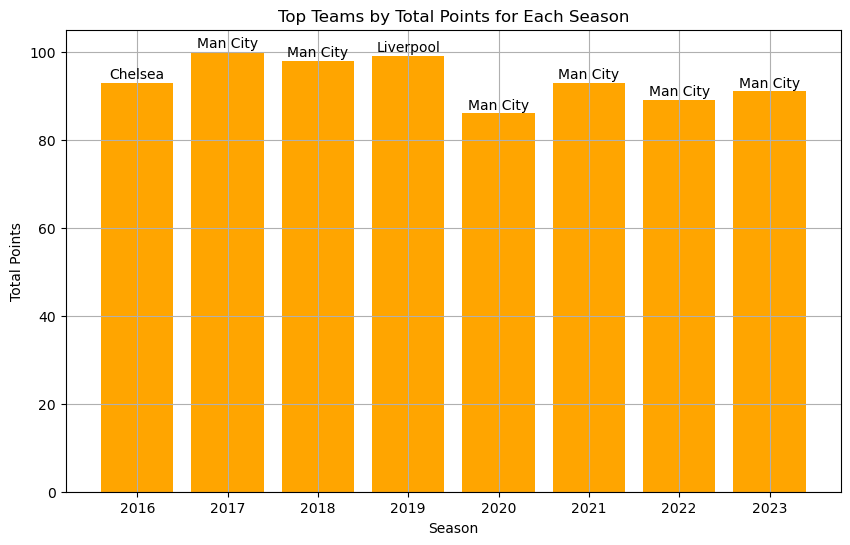

In [22]:
# Find the top team by points for each season
top_teams_by_season = seasons_combined.loc[seasons_combined.groupby('Season')['TotalPoints'].idxmax()]

# Plot the top teams by points for each season
plt.figure(figsize=(10, 6))
plt.bar(top_teams_by_season['Season'], top_teams_by_season['TotalPoints'], color='orange')
plt.title('Top Teams by Total Points for Each Season')
plt.xlabel('Season')
plt.ylabel('Total Points')
plt.xticks(top_teams_by_season['Season'])
plt.grid(True)

# Add labels to the bars
for i, row in top_teams_by_season.iterrows():
    plt.text(row['Season'], row['TotalPoints'] + 1, row['Team'], ha='center')

plt.show()


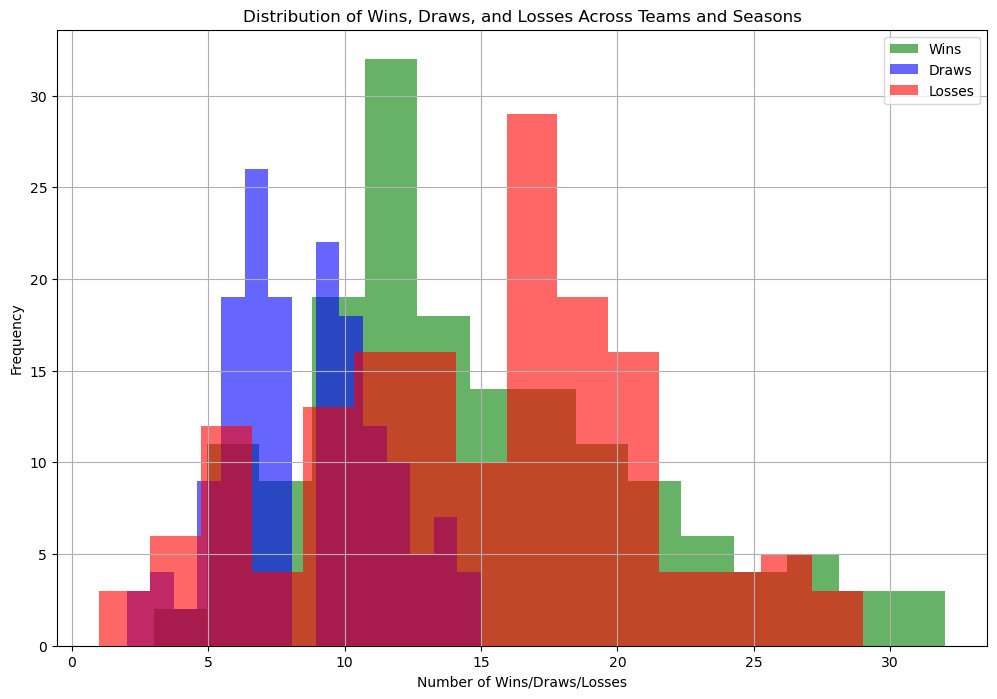

In [23]:
# Plot the distribution of wins, draws, and losses across all teams and seasons
plt.figure(figsize=(12, 8))

plt.hist(seasons_combined['TotalWins'], bins=15, alpha=0.6, color='green', label='Wins')
plt.hist(seasons_combined['TotalDraws'], bins=15, alpha=0.6, color='blue', label='Draws')
plt.hist(seasons_combined['TotalLosses'], bins=15, alpha=0.6, color='red', label='Losses')

plt.title('Distribution of Wins, Draws, and Losses Across Teams and Seasons')
plt.xlabel('Number of Wins/Draws/Losses')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Select only numeric columns for comparison
numeric_columns = ['TotalPoints', 'TotalGoalsScored', 'TotalGoalsConceded', 'TotalWins', 'TotalDraws', 'TotalLosses']

# Calculate the mean statistics for champion and non-champion teams
champion_stats = seasons_combined.groupby('Champion')[numeric_columns].mean()

# Display the statistics
print(champion_stats)


          TotalPoints  TotalGoalsScored  TotalGoalsConceded  TotalWins  \
Champion                                                                 
0           50.559211         51.776316           55.078947  13.921053   
1           93.625000         92.875000           30.125000  29.750000   

          TotalDraws  TotalLosses  
Champion                           
0           8.796053    15.282895  
1           4.375000     3.875000  


### Individual Team Analysis

### Arsenal

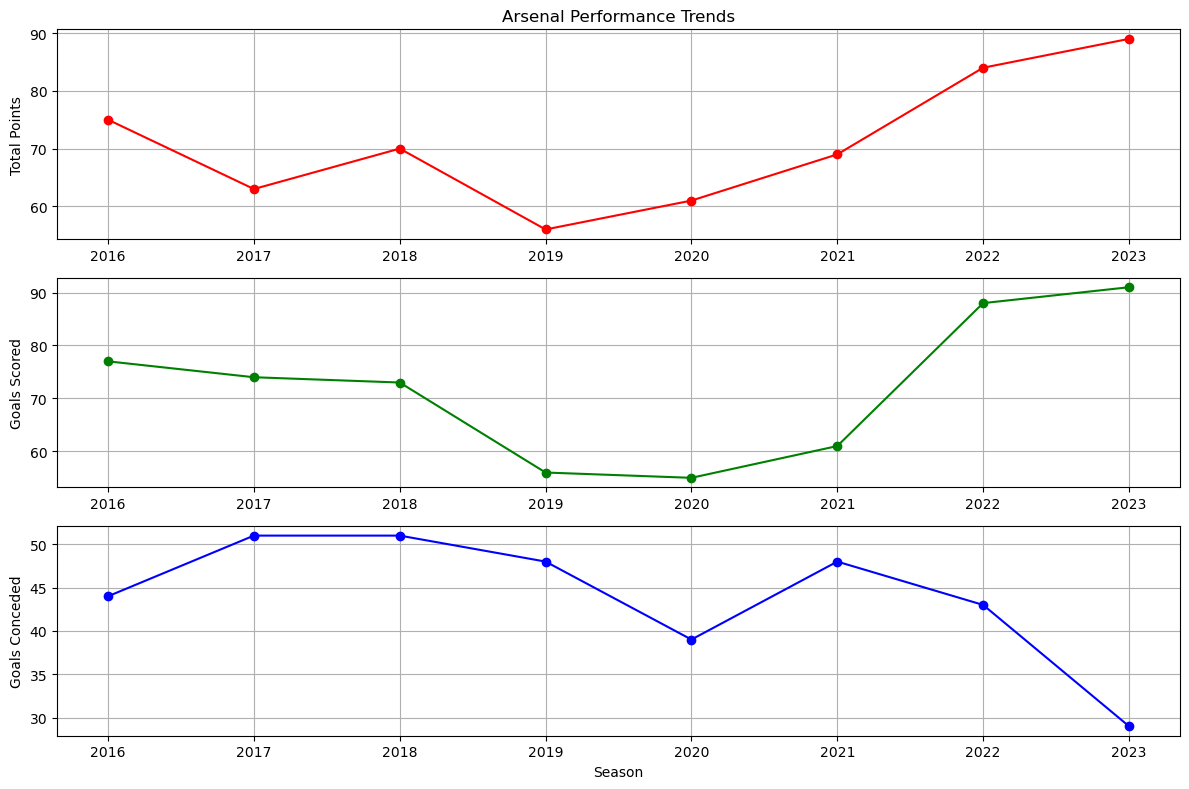

In [25]:
# Filter the data for Arsenal
arsenal_data = seasons_combined[seasons_combined['Team'] == 'Arsenal']

# Plot Arsenal's performance trends over the seasons
plt.figure(figsize=(12, 8))

# Points
plt.subplot(3, 1, 1)
plt.plot(arsenal_data['Season'], arsenal_data['TotalPoints'], marker='o', color='red')
plt.title('Arsenal Performance Trends')
plt.ylabel('Total Points')
plt.xticks(arsenal_data['Season'])
plt.grid(True)

# Goals Scored
plt.subplot(3, 1, 2)
plt.plot(arsenal_data['Season'], arsenal_data['TotalGoalsScored'], marker='o', color='green')
plt.ylabel('Goals Scored')
plt.xticks(arsenal_data['Season'])
plt.grid(True)

# Goals Conceded
plt.subplot(3, 1, 3)
plt.plot(arsenal_data['Season'], arsenal_data['TotalGoalsConceded'], marker='o', color='blue')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(arsenal_data['Season'])
plt.grid(True)

plt.tight_layout()
plt.show()

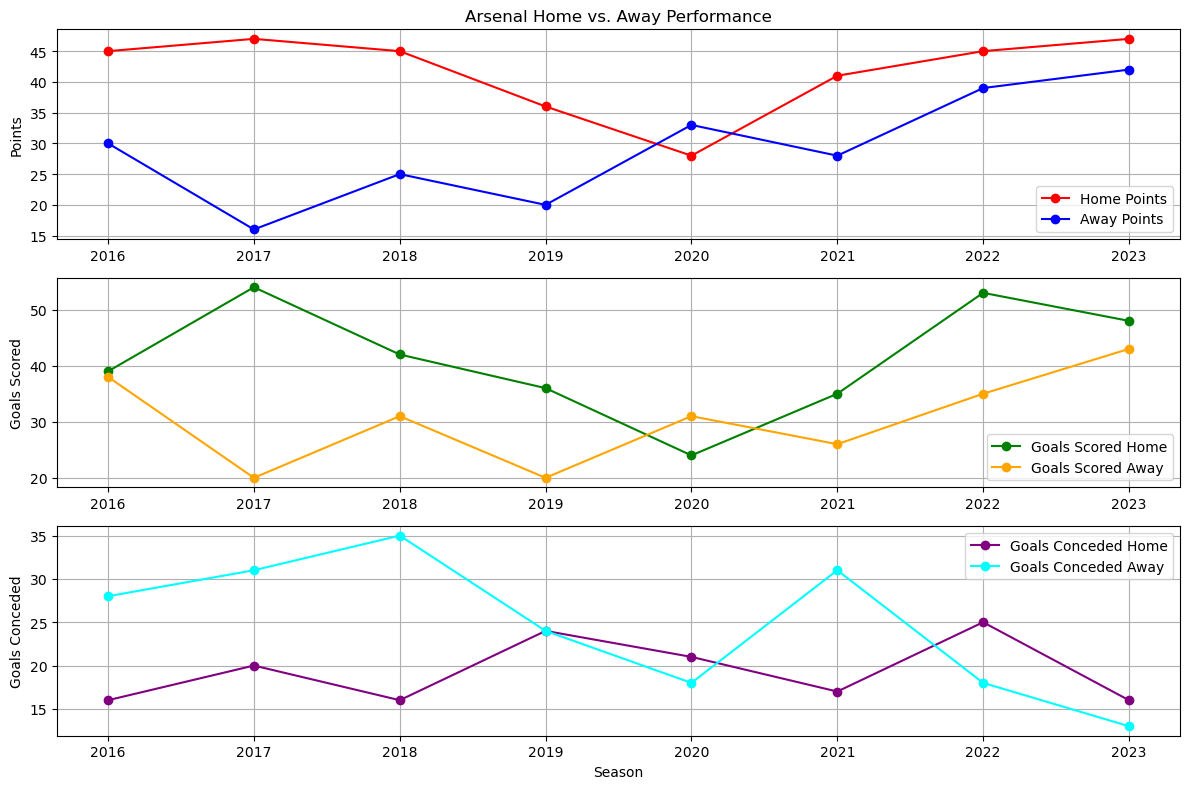

In [26]:
# Plot Arsenal's home vs. away performance over the seasons
plt.figure(figsize=(12, 8))

# Points Home vs. Away
plt.subplot(3, 1, 1)
plt.plot(arsenal_data['Season'], arsenal_data['Points_Home'], marker='o', color='red', label='Home Points')
plt.plot(arsenal_data['Season'], arsenal_data['Points_Away'], marker='o', color='blue', label='Away Points')
plt.title('Arsenal Home vs. Away Performance')
plt.ylabel('Points')
plt.xticks(arsenal_data['Season'])
plt.legend()
plt.grid(True)

# Goals Scored Home vs. Away
plt.subplot(3, 1, 2)
plt.plot(arsenal_data['Season'], arsenal_data['GoalsScored_Home'], marker='o', color='green', label='Goals Scored Home')
plt.plot(arsenal_data['Season'], arsenal_data['GoalsScored_Away'], marker='o', color='orange', label='Goals Scored Away')
plt.ylabel('Goals Scored')
plt.xticks(arsenal_data['Season'])
plt.legend()
plt.grid(True)

# Goals Conceded Home vs. Away
plt.subplot(3, 1, 3)
plt.plot(arsenal_data['Season'], arsenal_data['GoalsConceded_Home'], marker='o', color='purple', label='Goals Conceded Home')
plt.plot(arsenal_data['Season'], arsenal_data['GoalsConceded_Away'], marker='o', color='cyan', label='Goals Conceded Away')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(arsenal_data['Season'])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


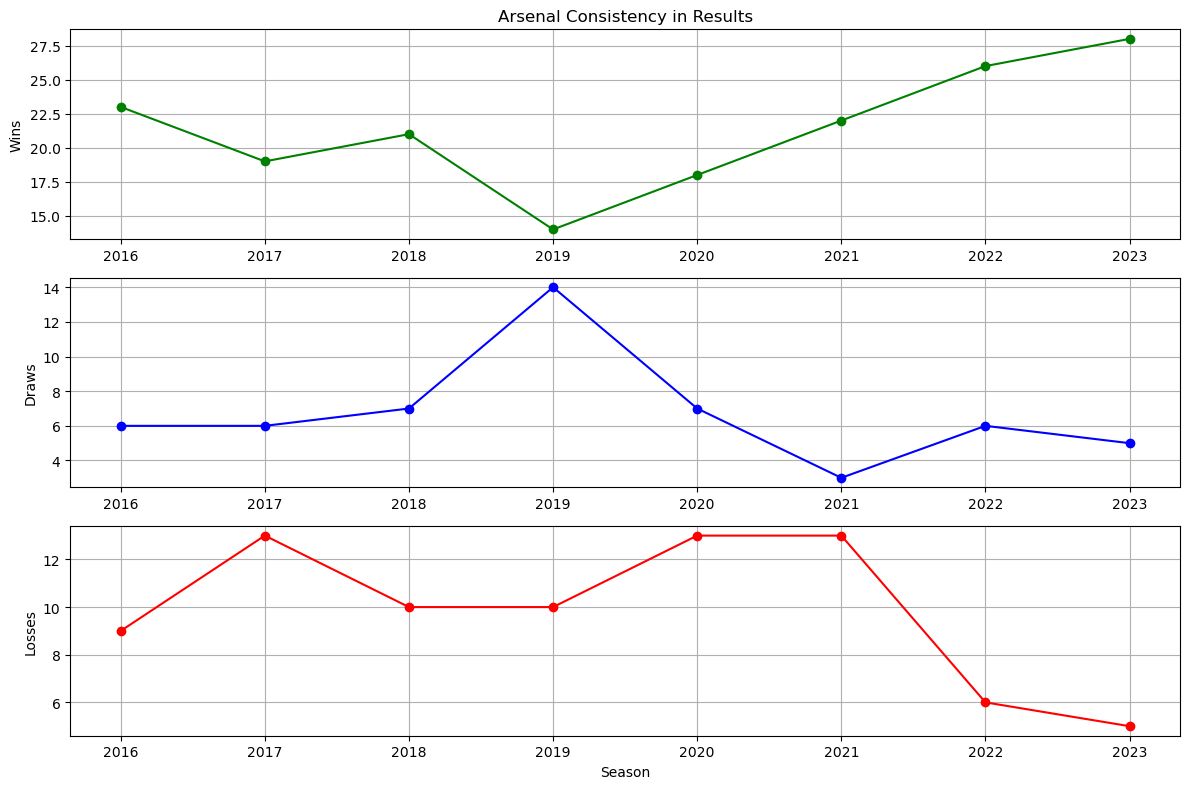

In [27]:
# Plot Arsenal's consistency in results over the seasons
plt.figure(figsize=(12, 8))

# Wins
plt.subplot(3, 1, 1)
plt.plot(arsenal_data['Season'], arsenal_data['TotalWins'], marker='o', color='green')
plt.title('Arsenal Consistency in Results')
plt.ylabel('Wins')
plt.xticks(arsenal_data['Season'])
plt.grid(True)

# Draws
plt.subplot(3, 1, 2)
plt.plot(arsenal_data['Season'], arsenal_data['TotalDraws'], marker='o', color='blue')
plt.ylabel('Draws')
plt.xticks(arsenal_data['Season'])
plt.grid(True)

# Losses
plt.subplot(3, 1, 3)
plt.plot(arsenal_data['Season'], arsenal_data['TotalLosses'], marker='o', color='red')
plt.ylabel('Losses')
plt.xlabel('Season')
plt.xticks(arsenal_data['Season'])
plt.grid(True)

plt.tight_layout()
plt.show()


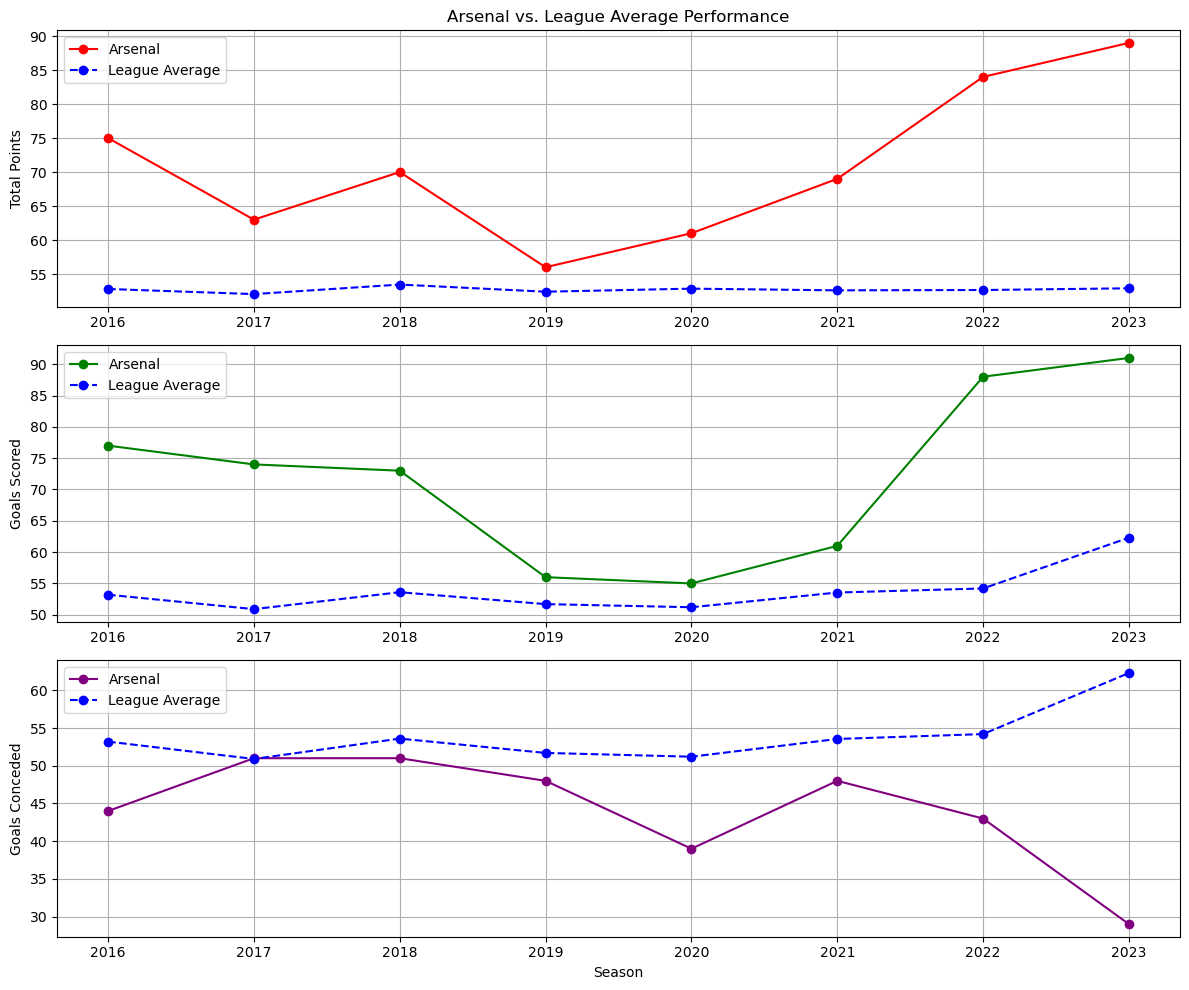

In [28]:
# Ensure that only numeric columns are selected for computing the league averages
league_average = seasons_combined.groupby('Season').mean(numeric_only=True)[['TotalPoints', 'TotalGoalsScored', 'TotalGoalsConceded']].reset_index()

# Merge Arsenal data with league averages
arsenal_vs_league = pd.merge(arsenal_data, league_average, on='Season', suffixes=('_Arsenal', '_League'))

# Plot the comparison of Arsenal vs. League average
plt.figure(figsize=(12, 10))

# Points
plt.subplot(3, 1, 1)
plt.plot(arsenal_vs_league['Season'], arsenal_vs_league['TotalPoints_Arsenal'], marker='o', color='red', label='Arsenal')
plt.plot(arsenal_vs_league['Season'], arsenal_vs_league['TotalPoints_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.title('Arsenal vs. League Average Performance')
plt.ylabel('Total Points')
plt.xticks(arsenal_vs_league['Season'])
plt.legend()
plt.grid(True)

# Goals Scored
plt.subplot(3, 1, 2)
plt.plot(arsenal_vs_league['Season'], arsenal_vs_league['TotalGoalsScored_Arsenal'], marker='o', color='green', label='Arsenal')
plt.plot(arsenal_vs_league['Season'], arsenal_vs_league['TotalGoalsScored_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.ylabel('Goals Scored')
plt.xticks(arsenal_vs_league['Season'])
plt.legend()
plt.grid(True)

# Goals Conceded
plt.subplot(3, 1, 3)
plt.plot(arsenal_vs_league['Season'], arsenal_vs_league['TotalGoalsConceded_Arsenal'], marker='o', color='purple', label='Arsenal')
plt.plot(arsenal_vs_league['Season'], arsenal_vs_league['TotalGoalsConceded_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(arsenal_vs_league['Season'])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Man City

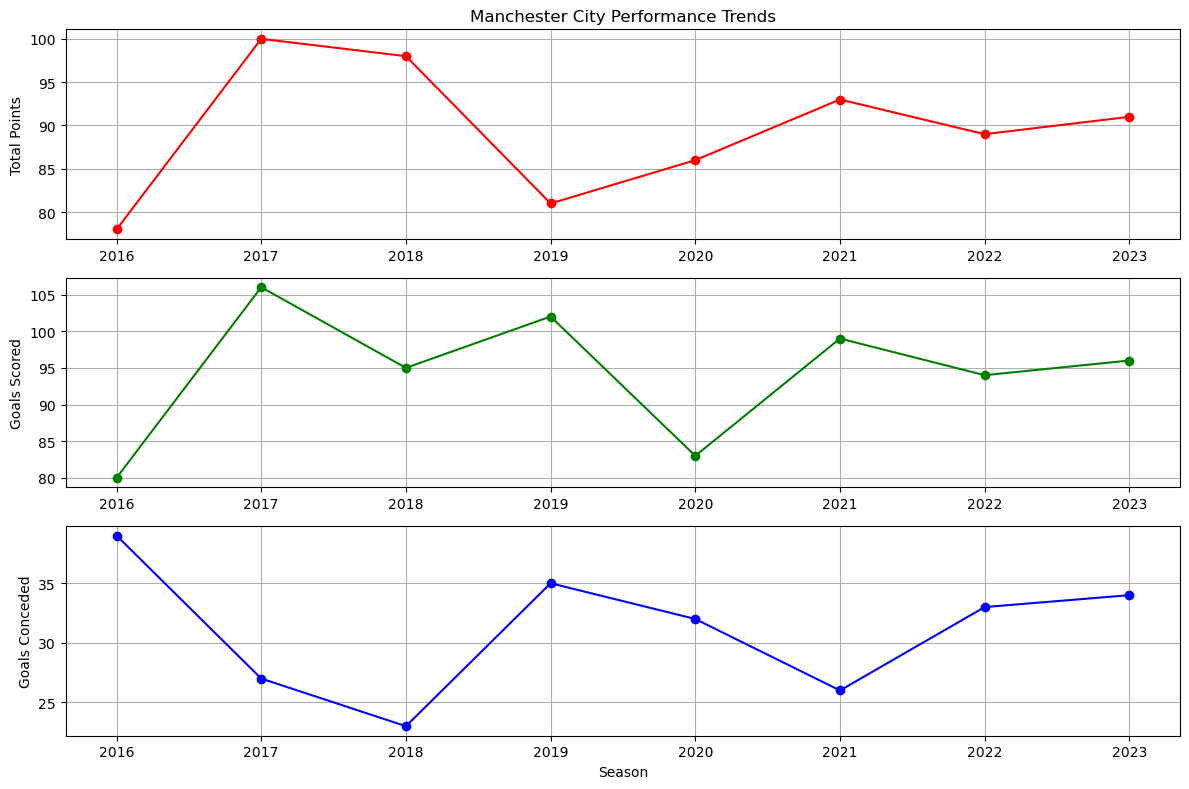

In [29]:
# Filter the data for Manchester City
man_city_data = seasons_combined[seasons_combined['Team'] == 'Man City']

# Plot Manchester City's performance trends over the seasons
plt.figure(figsize=(12, 8))

# Points
plt.subplot(3, 1, 1)
plt.plot(man_city_data['Season'], man_city_data['TotalPoints'], marker='o', color='red')
plt.title('Manchester City Performance Trends')
plt.ylabel('Total Points')
plt.xticks(man_city_data['Season'])
plt.grid(True)

# Goals Scored
plt.subplot(3, 1, 2)
plt.plot(man_city_data['Season'], man_city_data['TotalGoalsScored'], marker='o', color='green')
plt.ylabel('Goals Scored')
plt.xticks(man_city_data['Season'])
plt.grid(True)

# Goals Conceded
plt.subplot(3, 1, 3)
plt.plot(man_city_data['Season'], man_city_data['TotalGoalsConceded'], marker='o', color='blue')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(man_city_data['Season'])
plt.grid(True)

plt.tight_layout()
plt.show()

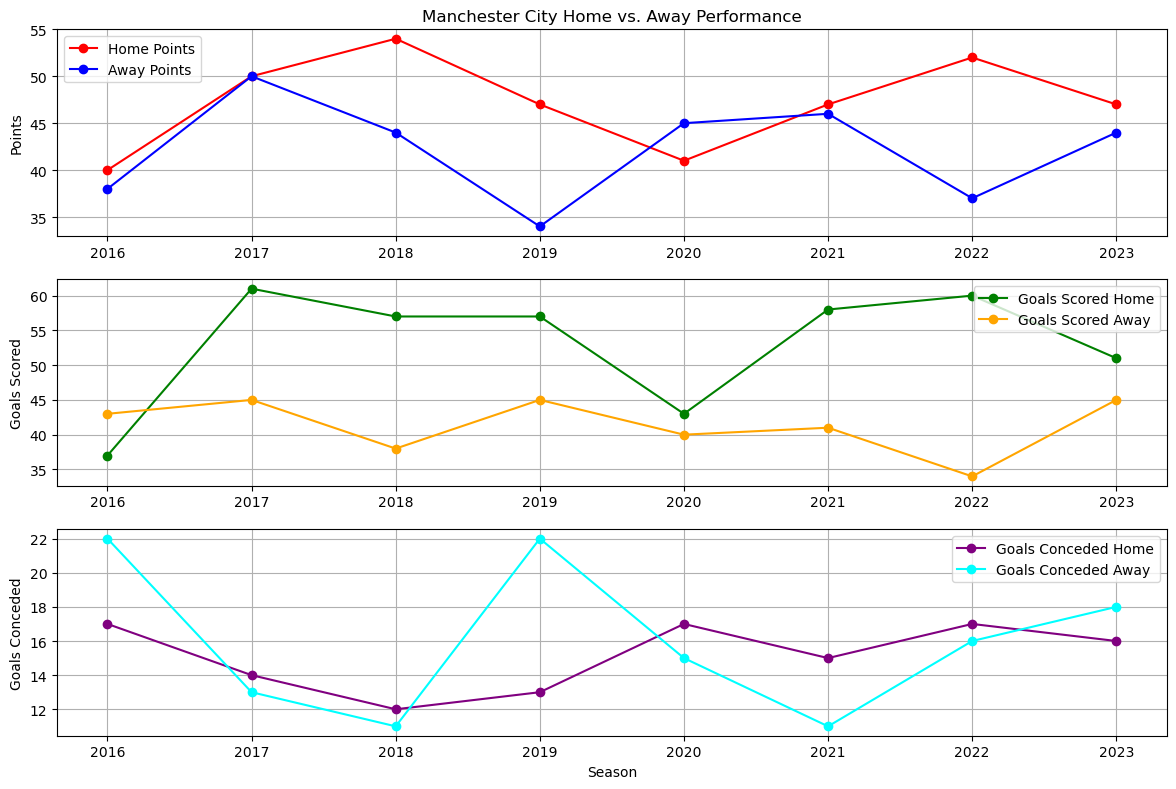

In [30]:
# Plot Manchester City's home vs. away performance over the seasons
plt.figure(figsize=(12, 8))

# Points Home vs. Away
plt.subplot(3, 1, 1)
plt.plot(man_city_data['Season'], man_city_data['Points_Home'], marker='o', color='red', label='Home Points')
plt.plot(man_city_data['Season'], man_city_data['Points_Away'], marker='o', color='blue', label='Away Points')
plt.title('Manchester City Home vs. Away Performance')
plt.ylabel('Points')
plt.xticks(man_city_data['Season'])
plt.legend()
plt.grid(True)

# Goals Scored Home vs. Away
plt.subplot(3, 1, 2)
plt.plot(man_city_data['Season'], man_city_data['GoalsScored_Home'], marker='o', color='green', label='Goals Scored Home')
plt.plot(man_city_data['Season'], man_city_data['GoalsScored_Away'], marker='o', color='orange', label='Goals Scored Away')
plt.ylabel('Goals Scored')
plt.xticks(man_city_data['Season'])
plt.legend()
plt.grid(True)

# Goals Conceded Home vs. Away
plt.subplot(3, 1, 3)
plt.plot(man_city_data['Season'], man_city_data['GoalsConceded_Home'], marker='o', color='purple', label='Goals Conceded Home')
plt.plot(man_city_data['Season'], man_city_data['GoalsConceded_Away'], marker='o', color='cyan', label='Goals Conceded Away')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(man_city_data['Season'])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


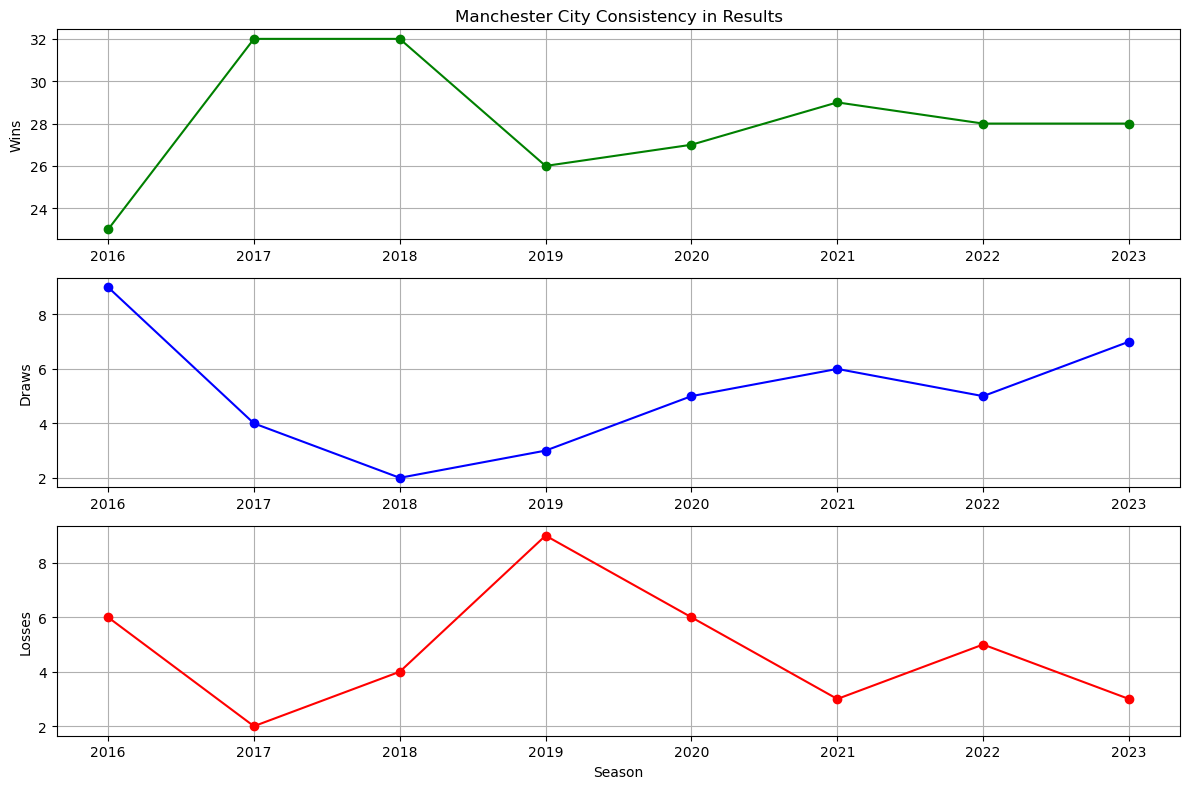

In [31]:
# Plot Manchester City's consistency in results over the seasons
plt.figure(figsize=(12, 8))

# Wins
plt.subplot(3, 1, 1)
plt.plot(man_city_data['Season'], man_city_data['TotalWins'], marker='o', color='green')
plt.title('Manchester City Consistency in Results')
plt.ylabel('Wins')
plt.xticks(man_city_data['Season'])
plt.grid(True)

# Draws
plt.subplot(3, 1, 2)
plt.plot(man_city_data['Season'], man_city_data['TotalDraws'], marker='o', color='blue')
plt.ylabel('Draws')
plt.xticks(man_city_data['Season'])
plt.grid(True)

# Losses
plt.subplot(3, 1, 3)
plt.plot(man_city_data['Season'], man_city_data['TotalLosses'], marker='o', color='red')
plt.ylabel('Losses')
plt.xlabel('Season')
plt.xticks(man_city_data['Season'])
plt.grid(True)

plt.tight_layout()
plt.show()


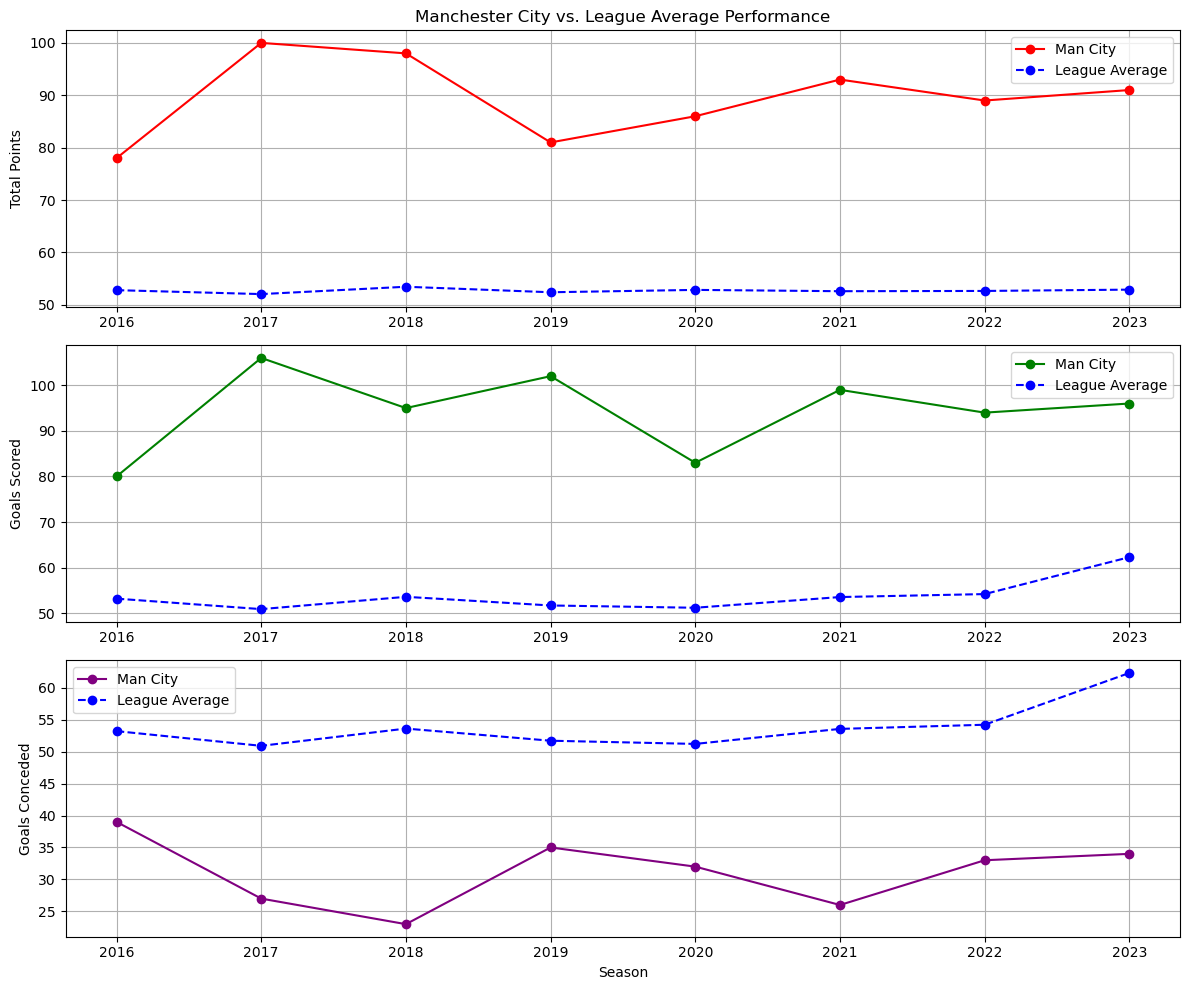

In [32]:
# Merge Manchester City data with league averages
man_city_vs_league = pd.merge(man_city_data, league_average, on='Season', suffixes=('_ManCity', '_League'))

# Plot the comparison of Manchester City vs. League average
plt.figure(figsize=(12, 10))

# Points
plt.subplot(3, 1, 1)
plt.plot(man_city_vs_league['Season'], man_city_vs_league['TotalPoints_ManCity'], marker='o', color='red', label='Man City')
plt.plot(man_city_vs_league['Season'], man_city_vs_league['TotalPoints_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.title('Manchester City vs. League Average Performance')
plt.ylabel('Total Points')
plt.xticks(man_city_vs_league['Season'])
plt.legend()
plt.grid(True)

# Goals Scored
plt.subplot(3, 1, 2)
plt.plot(man_city_vs_league['Season'], man_city_vs_league['TotalGoalsScored_ManCity'], marker='o', color='green', label='Man City')
plt.plot(man_city_vs_league['Season'], man_city_vs_league['TotalGoalsScored_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.ylabel('Goals Scored')
plt.xticks(man_city_vs_league['Season'])
plt.legend()
plt.grid(True)

# Goals Conceded
plt.subplot(3, 1, 3)
plt.plot(man_city_vs_league['Season'], man_city_vs_league['TotalGoalsConceded_ManCity'], marker='o', color='purple', label='Man City')
plt.plot(man_city_vs_league['Season'], man_city_vs_league['TotalGoalsConceded_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(man_city_vs_league['Season'])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Liverpool

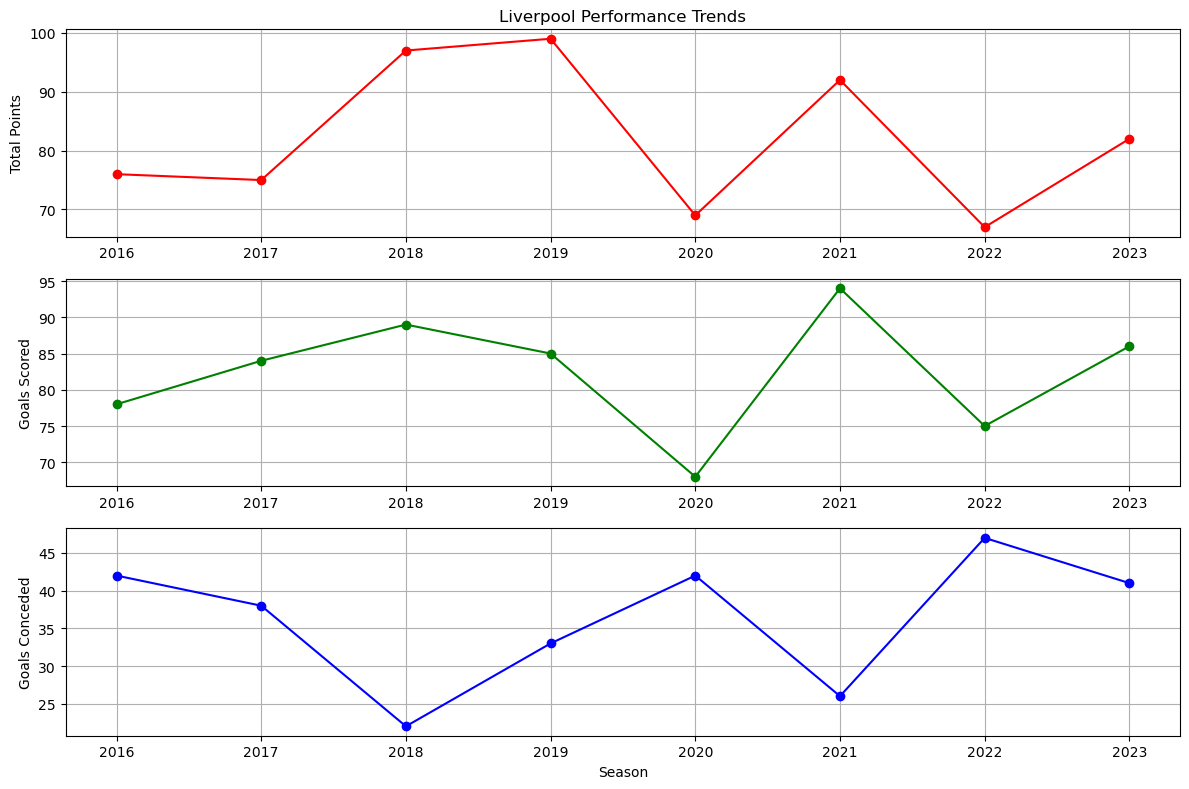

In [33]:
# Filter the data for Liverpool
liverpool_data = seasons_combined[seasons_combined['Team'] == 'Liverpool']

# Plot Liverpool's performance trends over the seasons
plt.figure(figsize=(12, 8))

# Points
plt.subplot(3, 1, 1)
plt.plot(liverpool_data['Season'], liverpool_data['TotalPoints'], marker='o', color='red')
plt.title('Liverpool Performance Trends')
plt.ylabel('Total Points')
plt.xticks(liverpool_data['Season'])
plt.grid(True)

# Goals Scored
plt.subplot(3, 1, 2)
plt.plot(liverpool_data['Season'], liverpool_data['TotalGoalsScored'], marker='o', color='green')
plt.ylabel('Goals Scored')
plt.xticks(liverpool_data['Season'])
plt.grid(True)

# Goals Conceded
plt.subplot(3, 1, 3)
plt.plot(liverpool_data['Season'], liverpool_data['TotalGoalsConceded'], marker='o', color='blue')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(liverpool_data['Season'])
plt.grid(True)

plt.tight_layout()
plt.show()

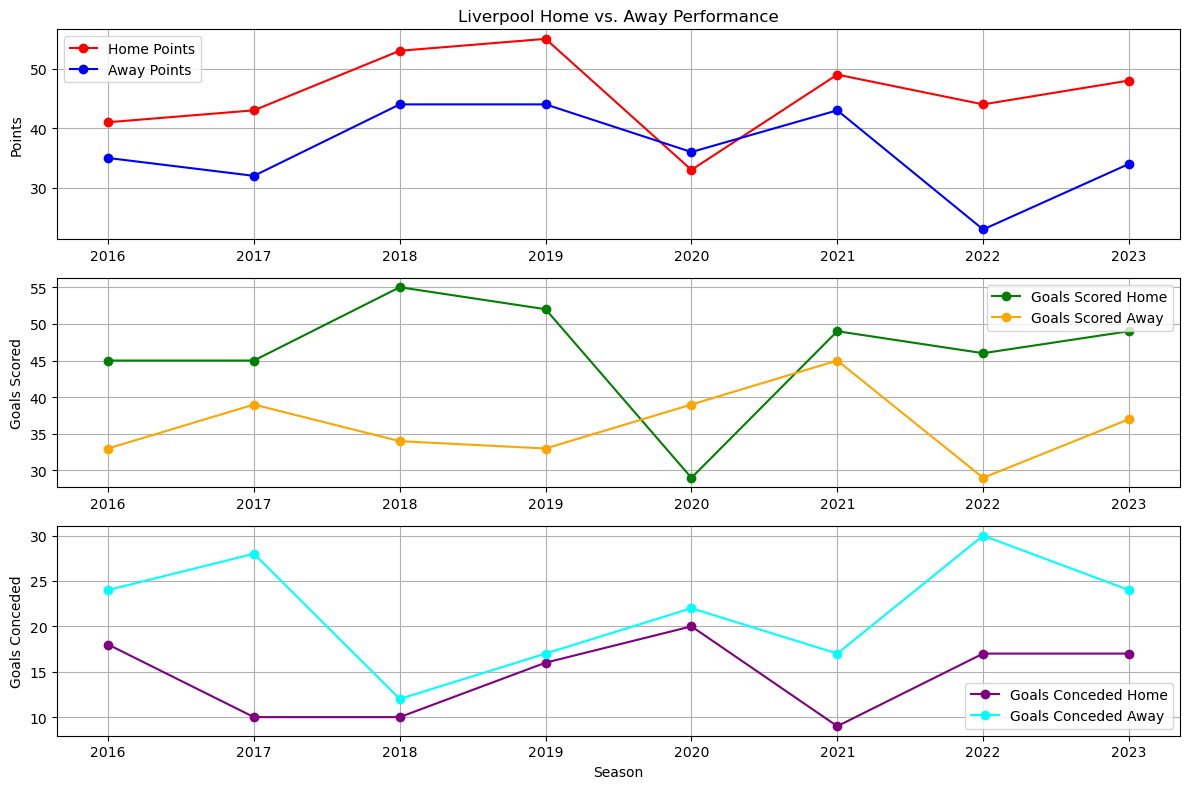

In [34]:
# Plot Liverpool's home vs. away performance over the seasons
plt.figure(figsize=(12, 8))

# Points Home vs. Away
plt.subplot(3, 1, 1)
plt.plot(liverpool_data['Season'], liverpool_data['Points_Home'], marker='o', color='red', label='Home Points')
plt.plot(liverpool_data['Season'], liverpool_data['Points_Away'], marker='o', color='blue', label='Away Points')
plt.title('Liverpool Home vs. Away Performance')
plt.ylabel('Points')
plt.xticks(liverpool_data['Season'])
plt.legend()
plt.grid(True)

# Goals Scored Home vs. Away
plt.subplot(3, 1, 2)
plt.plot(liverpool_data['Season'], liverpool_data['GoalsScored_Home'], marker='o', color='green', label='Goals Scored Home')
plt.plot(liverpool_data['Season'], liverpool_data['GoalsScored_Away'], marker='o', color='orange', label='Goals Scored Away')
plt.ylabel('Goals Scored')
plt.xticks(liverpool_data['Season'])
plt.legend()
plt.grid(True)

# Goals Conceded Home vs. Away
plt.subplot(3, 1, 3)
plt.plot(liverpool_data['Season'], liverpool_data['GoalsConceded_Home'], marker='o', color='purple', label='Goals Conceded Home')
plt.plot(liverpool_data['Season'], liverpool_data['GoalsConceded_Away'], marker='o', color='cyan', label='Goals Conceded Away')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(liverpool_data['Season'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


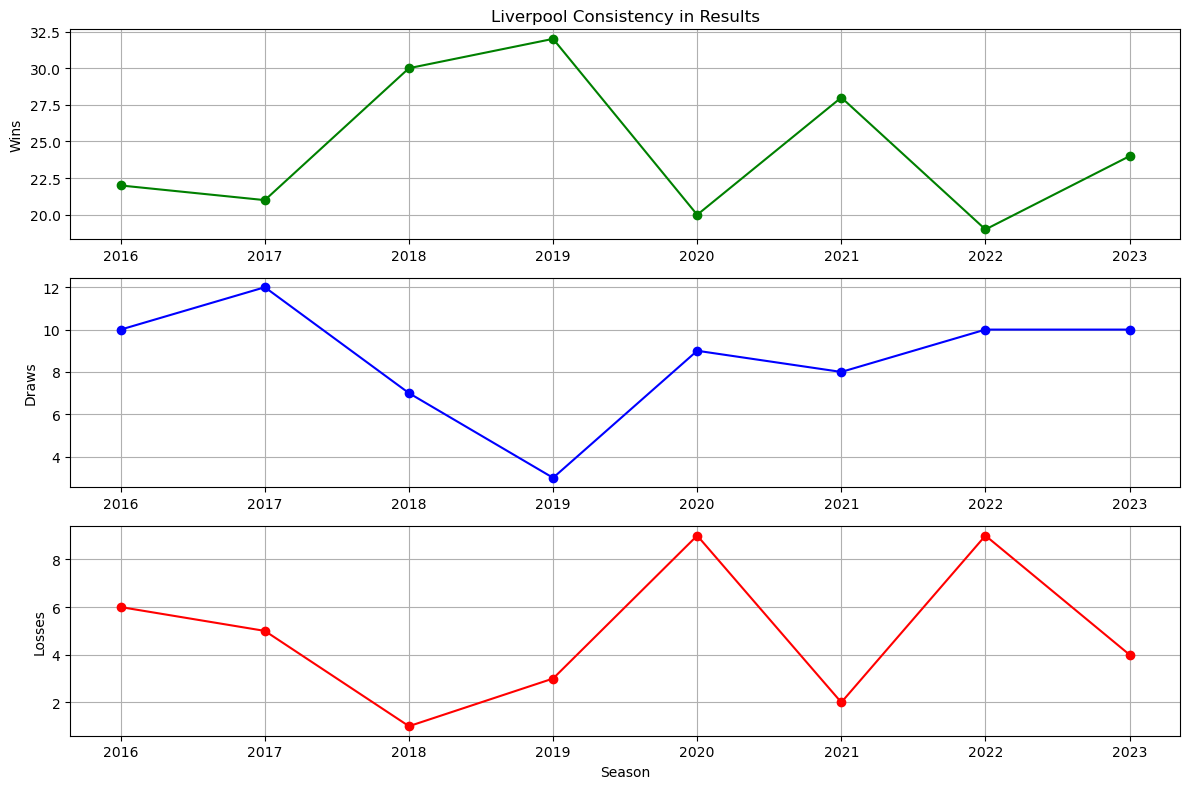

In [35]:
# Plot Liverpool's consistency in results over the seasons
plt.figure(figsize=(12, 8))

# Wins
plt.subplot(3, 1, 1)
plt.plot(liverpool_data['Season'], liverpool_data['TotalWins'], marker='o', color='green')
plt.title('Liverpool Consistency in Results')
plt.ylabel('Wins')
plt.xticks(liverpool_data['Season'])
plt.grid(True)

# Draws
plt.subplot(3, 1, 2)
plt.plot(liverpool_data['Season'], liverpool_data['TotalDraws'], marker='o', color='blue')
plt.ylabel('Draws')
plt.xticks(liverpool_data['Season'])
plt.grid(True)

# Losses
plt.subplot(3, 1, 3)
plt.plot(liverpool_data['Season'], liverpool_data['TotalLosses'], marker='o', color='red')
plt.ylabel('Losses')
plt.xlabel('Season')
plt.xticks(liverpool_data['Season'])
plt.grid(True)

plt.tight_layout()
plt.show()


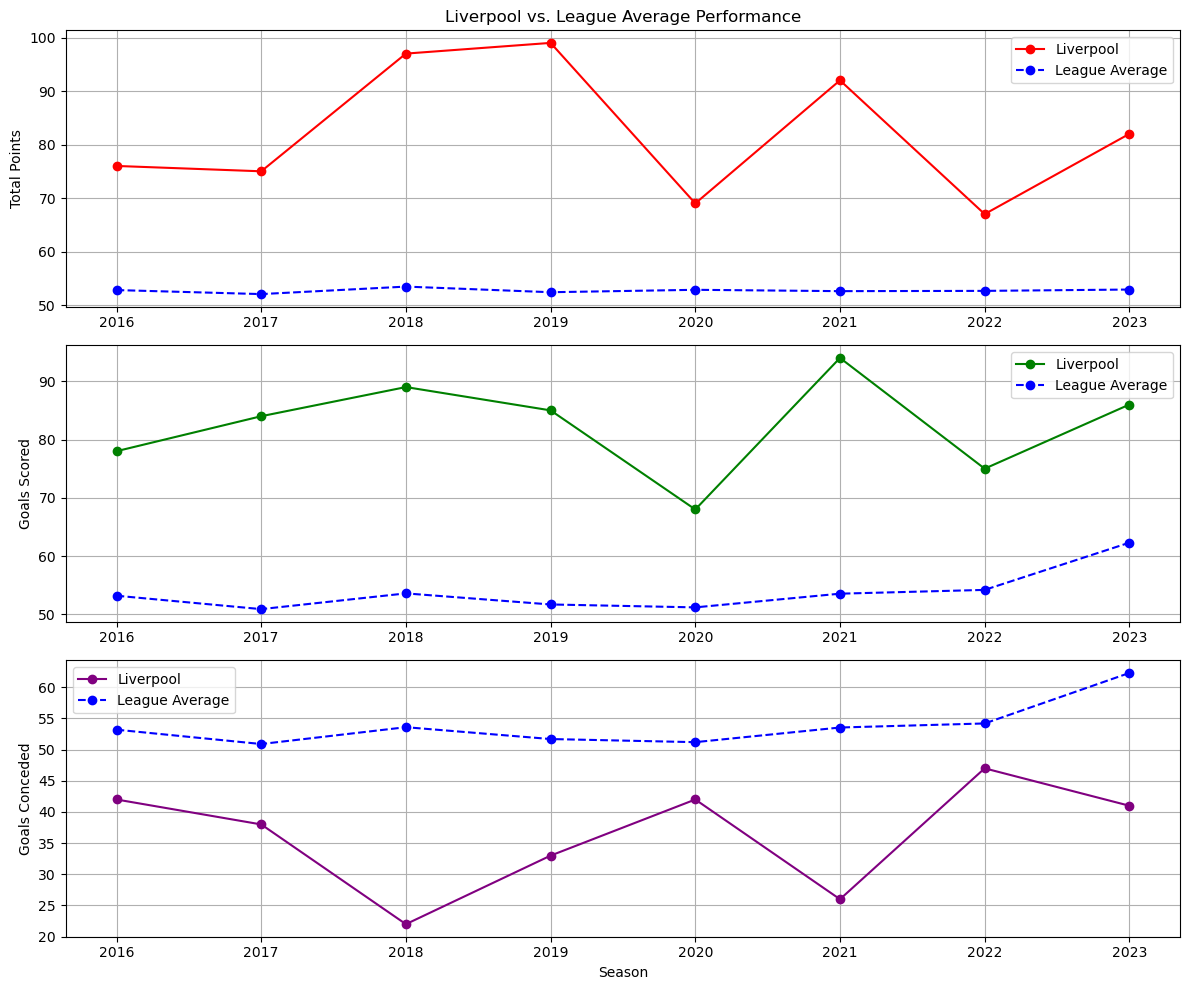

In [36]:
# Merge Liverpool data with league averages
liverpool_vs_league = pd.merge(liverpool_data, league_average, on='Season', suffixes=('_Liverpool', '_League'))

# Plot the comparison of Liverpool vs. League average
plt.figure(figsize=(12, 10))

# Points
plt.subplot(3, 1, 1)
plt.plot(liverpool_vs_league['Season'], liverpool_vs_league['TotalPoints_Liverpool'], marker='o', color='red', label='Liverpool')
plt.plot(liverpool_vs_league['Season'], liverpool_vs_league['TotalPoints_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.title('Liverpool vs. League Average Performance')
plt.ylabel('Total Points')
plt.xticks(liverpool_vs_league['Season'])
plt.legend()
plt.grid(True)

# Goals Scored
plt.subplot(3, 1, 2)
plt.plot(liverpool_vs_league['Season'], liverpool_vs_league['TotalGoalsScored_Liverpool'], marker='o', color='green', label='Liverpool')
plt.plot(liverpool_vs_league['Season'], liverpool_vs_league['TotalGoalsScored_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.ylabel('Goals Scored')
plt.xticks(liverpool_vs_league['Season'])
plt.legend()
plt.grid(True)

# Goals Conceded
plt.subplot(3, 1, 3)
plt.plot(liverpool_vs_league['Season'], liverpool_vs_league['TotalGoalsConceded_Liverpool'], marker='o', color='purple', label='Liverpool')
plt.plot(liverpool_vs_league['Season'], liverpool_vs_league['TotalGoalsConceded_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(liverpool_vs_league['Season'])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Man United

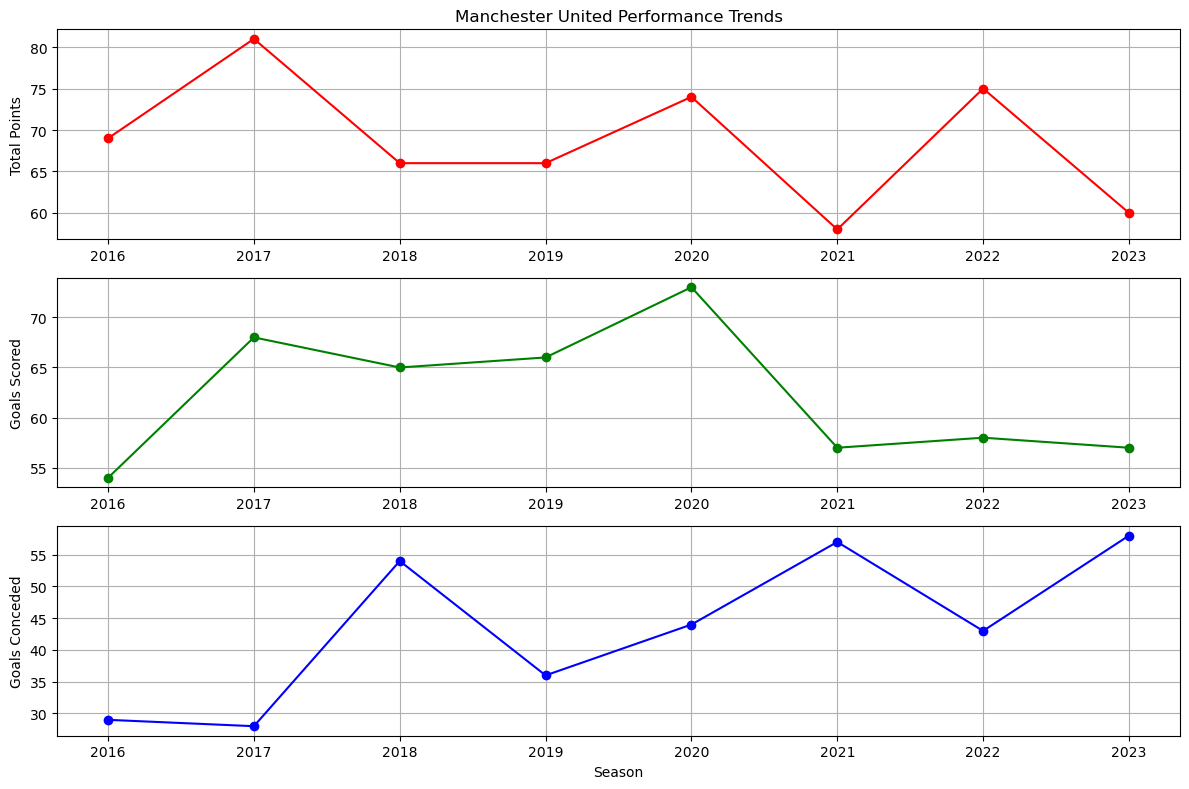

In [37]:
# Filter the data for Manchester United
man_united_data = seasons_combined[seasons_combined['Team'] == 'Man United']

# Plot Manchester United's performance trends over the seasons
plt.figure(figsize=(12, 8))

# Points
plt.subplot(3, 1, 1)
plt.plot(man_united_data['Season'], man_united_data['TotalPoints'], marker='o', color='red')
plt.title('Manchester United Performance Trends')
plt.ylabel('Total Points')
plt.xticks(man_united_data['Season'])
plt.grid(True)

# Goals Scored
plt.subplot(3, 1, 2)
plt.plot(man_united_data['Season'], man_united_data['TotalGoalsScored'], marker='o', color='green')
plt.ylabel('Goals Scored')
plt.xticks(man_united_data['Season'])
plt.grid(True)

# Goals Conceded
plt.subplot(3, 1, 3)
plt.plot(man_united_data['Season'], man_united_data['TotalGoalsConceded'], marker='o', color='blue')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(man_united_data['Season'])
plt.grid(True)

plt.tight_layout()
plt.show()


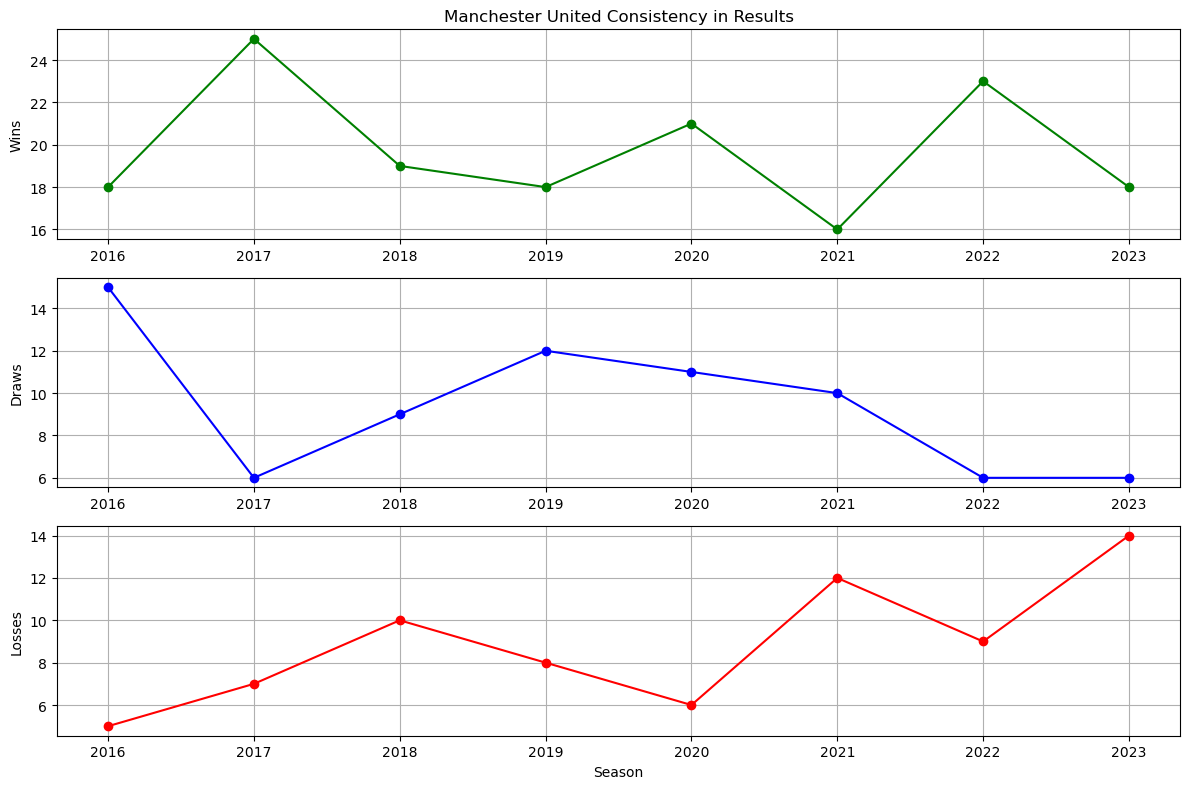

In [38]:
# Plot Manchester United's consistency in results over the seasons
plt.figure(figsize=(12, 8))

# Wins
plt.subplot(3, 1, 1)
plt.plot(man_united_data['Season'], man_united_data['TotalWins'], marker='o', color='green')
plt.title('Manchester United Consistency in Results')
plt.ylabel('Wins')
plt.xticks(man_united_data['Season'])
plt.grid(True)

# Draws
plt.subplot(3, 1, 2)
plt.plot(man_united_data['Season'], man_united_data['TotalDraws'], marker='o', color='blue')
plt.ylabel('Draws')
plt.xticks(man_united_data['Season'])
plt.grid(True)

# Losses
plt.subplot(3, 1, 3)
plt.plot(man_united_data['Season'], man_united_data['TotalLosses'], marker='o', color='red')
plt.ylabel('Losses')
plt.xlabel('Season')
plt.xticks(man_united_data['Season'])
plt.grid(True)

plt.tight_layout()
plt.show()


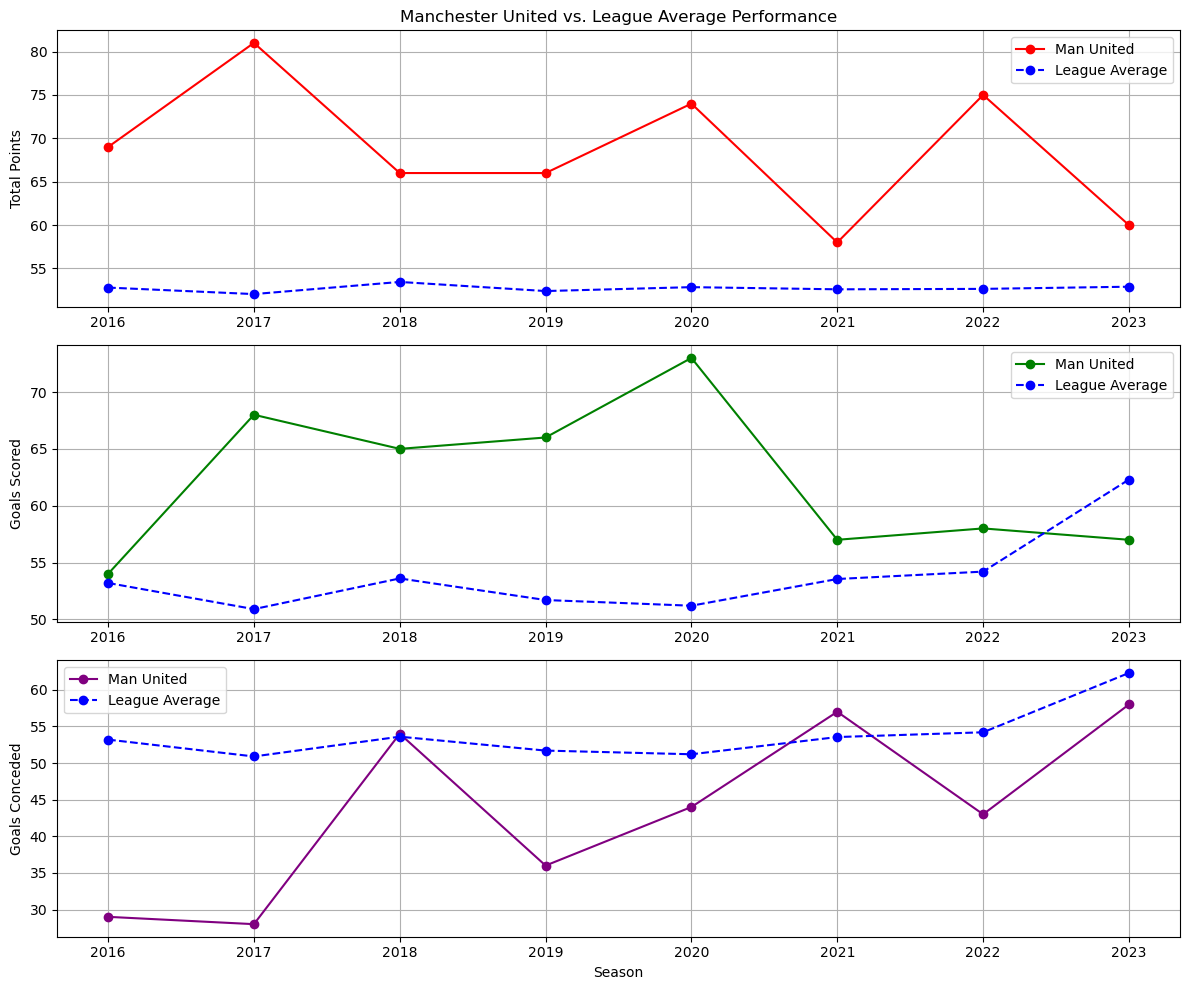

In [39]:
# Merge Manchester United data with league averages
man_united_vs_league = pd.merge(man_united_data, league_average, on='Season', suffixes=('_ManUnited', '_League'))

# Plot the comparison of Manchester United vs. League average
plt.figure(figsize=(12, 10))

# Points
plt.subplot(3, 1, 1)
plt.plot(man_united_vs_league['Season'], man_united_vs_league['TotalPoints_ManUnited'], marker='o', color='red', label='Man United')
plt.plot(man_united_vs_league['Season'], man_united_vs_league['TotalPoints_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.title('Manchester United vs. League Average Performance')
plt.ylabel('Total Points')
plt.xticks(man_united_vs_league['Season'])
plt.legend()
plt.grid(True)

# Goals Scored
plt.subplot(3, 1, 2)
plt.plot(man_united_vs_league['Season'], man_united_vs_league['TotalGoalsScored_ManUnited'], marker='o', color='green', label='Man United')
plt.plot(man_united_vs_league['Season'], man_united_vs_league['TotalGoalsScored_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.ylabel('Goals Scored')
plt.xticks(man_united_vs_league['Season'])
plt.legend()
plt.grid(True)

# Goals Conceded
plt.subplot(3, 1, 3)
plt.plot(man_united_vs_league['Season'], man_united_vs_league['TotalGoalsConceded_ManUnited'], marker='o', color='purple', label='Man United')
plt.plot(man_united_vs_league['Season'], man_united_vs_league['TotalGoalsConceded_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(man_united_vs_league['Season'])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Chelsea

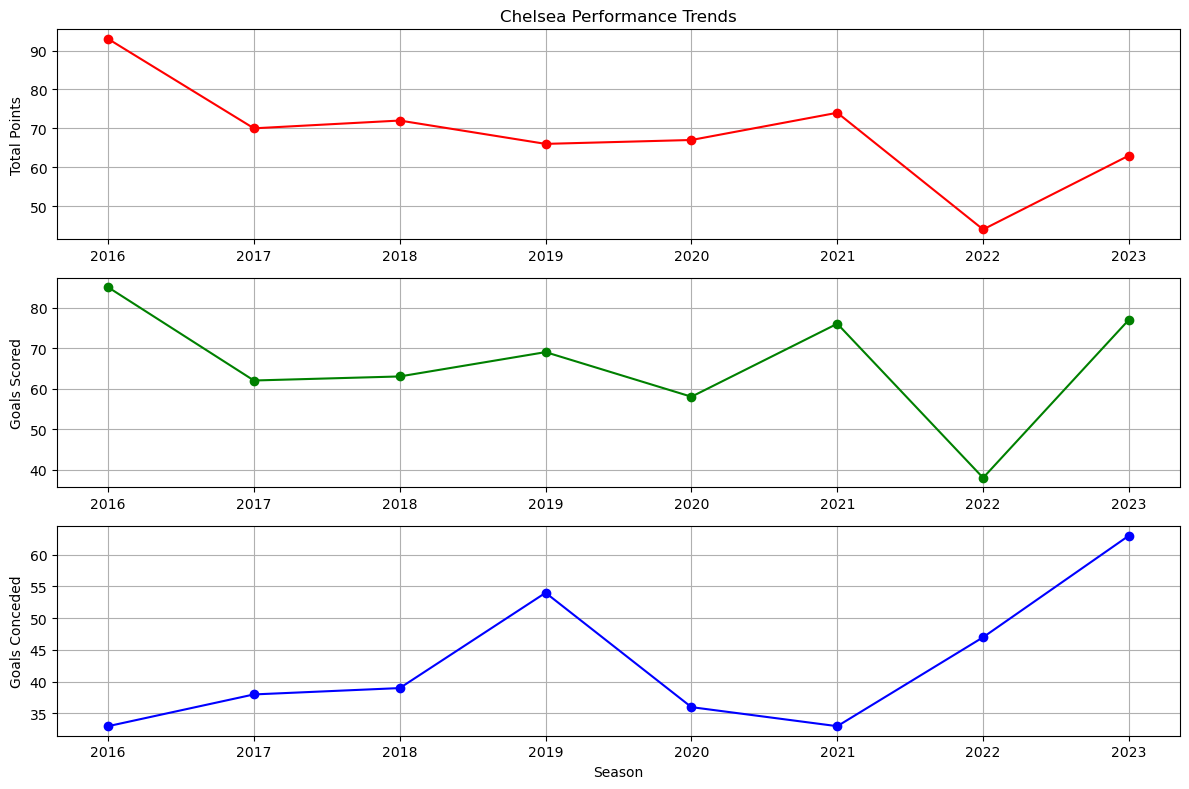

In [40]:
# Filter the data for Chelsea
chelsea_data = seasons_combined[seasons_combined['Team'] == 'Chelsea']

# Plot Chelsea's performance trends over the seasons
plt.figure(figsize=(12, 8))

# Points
plt.subplot(3, 1, 1)
plt.plot(chelsea_data['Season'], chelsea_data['TotalPoints'], marker='o', color='red')
plt.title('Chelsea Performance Trends')
plt.ylabel('Total Points')
plt.xticks(chelsea_data['Season'])
plt.grid(True)

# Goals Scored
plt.subplot(3, 1, 2)
plt.plot(chelsea_data['Season'], chelsea_data['TotalGoalsScored'], marker='o', color='green')
plt.ylabel('Goals Scored')
plt.xticks(chelsea_data['Season'])
plt.grid(True)

# Goals Conceded
plt.subplot(3, 1, 3)
plt.plot(chelsea_data['Season'], chelsea_data['TotalGoalsConceded'], marker='o', color='blue')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(chelsea_data['Season'])
plt.grid(True)

plt.tight_layout()
plt.show()

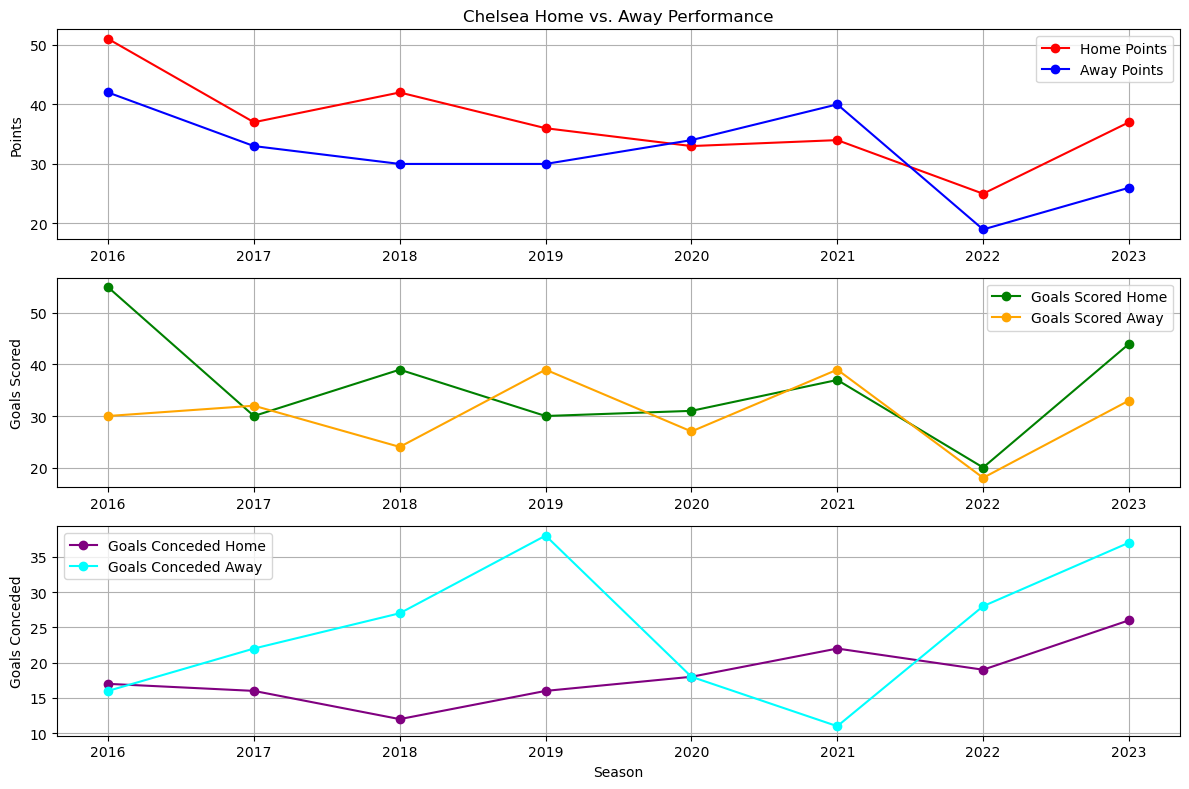

In [41]:
# Plot Chelsea's home vs. away performance over the seasons
plt.figure(figsize=(12, 8))

# Points Home vs. Away
plt.subplot(3, 1, 1)
plt.plot(chelsea_data['Season'], chelsea_data['Points_Home'], marker='o', color='red', label='Home Points')
plt.plot(chelsea_data['Season'], chelsea_data['Points_Away'], marker='o', color='blue', label='Away Points')
plt.title('Chelsea Home vs. Away Performance')
plt.ylabel('Points')
plt.xticks(chelsea_data['Season'])
plt.legend()
plt.grid(True)

# Goals Scored Home vs. Away
plt.subplot(3, 1, 2)
plt.plot(chelsea_data['Season'], chelsea_data['GoalsScored_Home'], marker='o', color='green', label='Goals Scored Home')
plt.plot(chelsea_data['Season'], chelsea_data['GoalsScored_Away'], marker='o', color='orange', label='Goals Scored Away')
plt.ylabel('Goals Scored')
plt.xticks(chelsea_data['Season'])
plt.legend()
plt.grid(True)

# Goals Conceded Home vs. Away
plt.subplot(3, 1, 3)
plt.plot(chelsea_data['Season'], chelsea_data['GoalsConceded_Home'], marker='o', color='purple', label='Goals Conceded Home')
plt.plot(chelsea_data['Season'], chelsea_data['GoalsConceded_Away'], marker='o', color='cyan', label='Goals Conceded Away')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(chelsea_data['Season'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


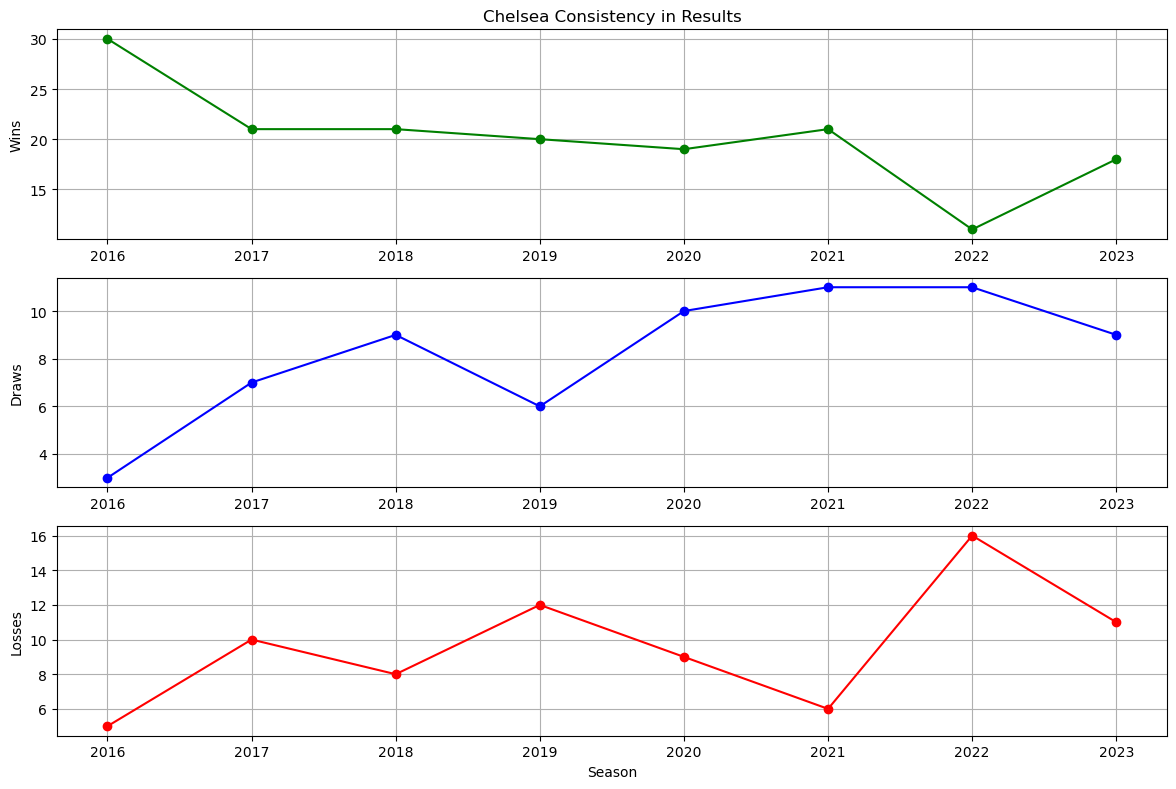

In [42]:
# Plot Chelsea's consistency in results over the seasons
plt.figure(figsize=(12, 8))

# Wins
plt.subplot(3, 1, 1)
plt.plot(chelsea_data['Season'], chelsea_data['TotalWins'], marker='o', color='green')
plt.title('Chelsea Consistency in Results')
plt.ylabel('Wins')
plt.xticks(chelsea_data['Season'])
plt.grid(True)

# Draws
plt.subplot(3, 1, 2)
plt.plot(chelsea_data['Season'], chelsea_data['TotalDraws'], marker='o', color='blue')
plt.ylabel('Draws')
plt.xticks(chelsea_data['Season'])
plt.grid(True)

# Losses
plt.subplot(3, 1, 3)
plt.plot(chelsea_data['Season'], chelsea_data['TotalLosses'], marker='o', color='red')
plt.ylabel('Losses')
plt.xlabel('Season')
plt.xticks(chelsea_data['Season'])
plt.grid(True)

plt.tight_layout()
plt.show()


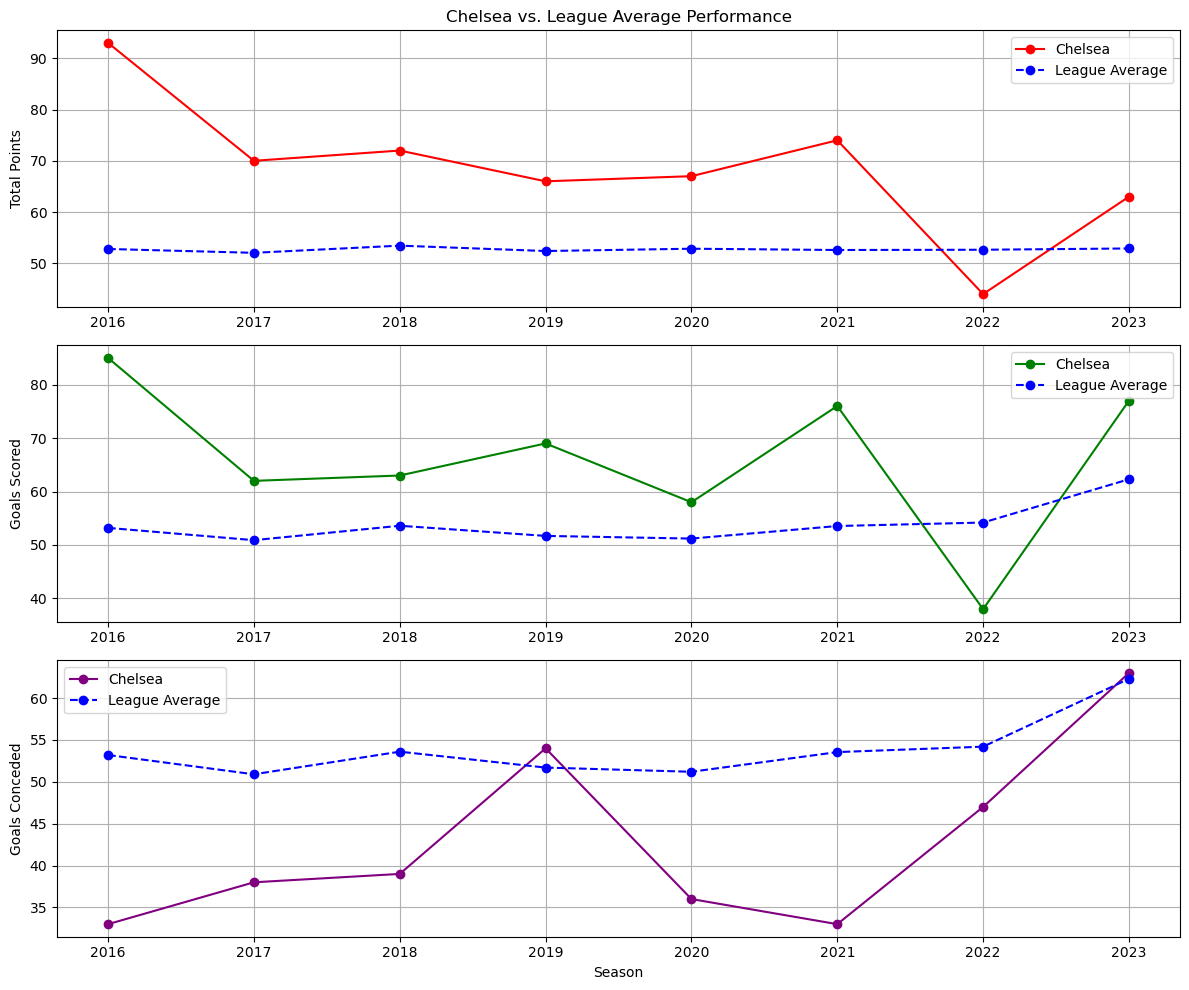

In [43]:
# Merge Chelsea data with league averages
chelsea_vs_league = pd.merge(chelsea_data, league_average, on='Season', suffixes=('_Chelsea', '_League'))

# Plot the comparison of Chelsea vs. League average
plt.figure(figsize=(12, 10))

# Points
plt.subplot(3, 1, 1)
plt.plot(chelsea_vs_league['Season'], chelsea_vs_league['TotalPoints_Chelsea'], marker='o', color='red', label='Chelsea')
plt.plot(chelsea_vs_league['Season'], chelsea_vs_league['TotalPoints_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.title('Chelsea vs. League Average Performance')
plt.ylabel('Total Points')
plt.xticks(chelsea_vs_league['Season'])
plt.legend()
plt.grid(True)

# Goals Scored
plt.subplot(3, 1, 2)
plt.plot(chelsea_vs_league['Season'], chelsea_vs_league['TotalGoalsScored_Chelsea'], marker='o', color='green', label='Chelsea')
plt.plot(chelsea_vs_league['Season'], chelsea_vs_league['TotalGoalsScored_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.ylabel('Goals Scored')
plt.xticks(chelsea_vs_league['Season'])
plt.legend()
plt.grid(True)

# Goals Conceded
plt.subplot(3, 1, 3)
plt.plot(chelsea_vs_league['Season'], chelsea_vs_league['TotalGoalsConceded_Chelsea'], marker='o', color='purple', label='Chelsea')
plt.plot(chelsea_vs_league['Season'], chelsea_vs_league['TotalGoalsConceded_League'], marker='o', color='blue', linestyle='--', label='League Average')
plt.ylabel('Goals Conceded')
plt.xlabel('Season')
plt.xticks(chelsea_vs_league['Season'])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Top-5 Teams Trend Analysis

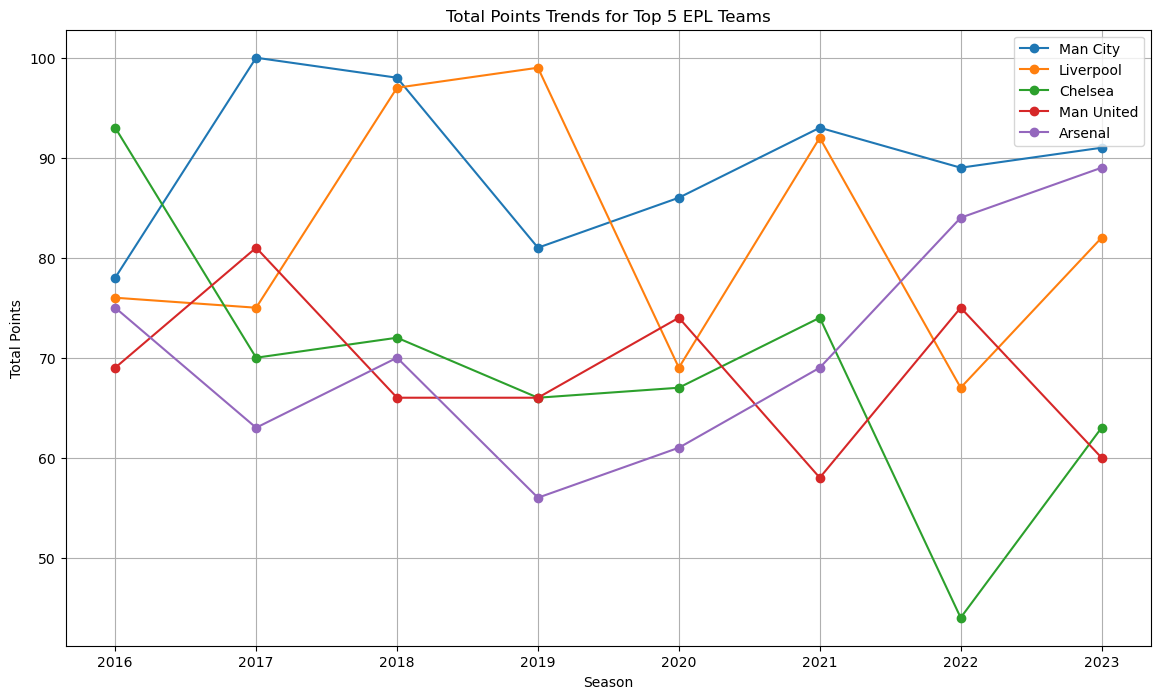

In [44]:
# Filter data for the top five teams
top_teams = ['Man City', 'Liverpool', 'Chelsea', 'Man United', 'Arsenal']
top_teams_data = seasons_combined[seasons_combined['Team'].isin(top_teams)]

# Plot the total points trends for the top five teams
plt.figure(figsize=(14, 8))

for team in top_teams:
    team_data = top_teams_data[top_teams_data['Team'] == team]
    plt.plot(team_data['Season'], team_data['TotalPoints'], marker='o', label=team)

plt.title('Total Points Trends for Top 5 EPL Teams')
plt.xlabel('Season')
plt.ylabel('Total Points')
plt.xticks(top_teams_data['Season'].unique())
plt.legend()
plt.grid(True)
plt.show()


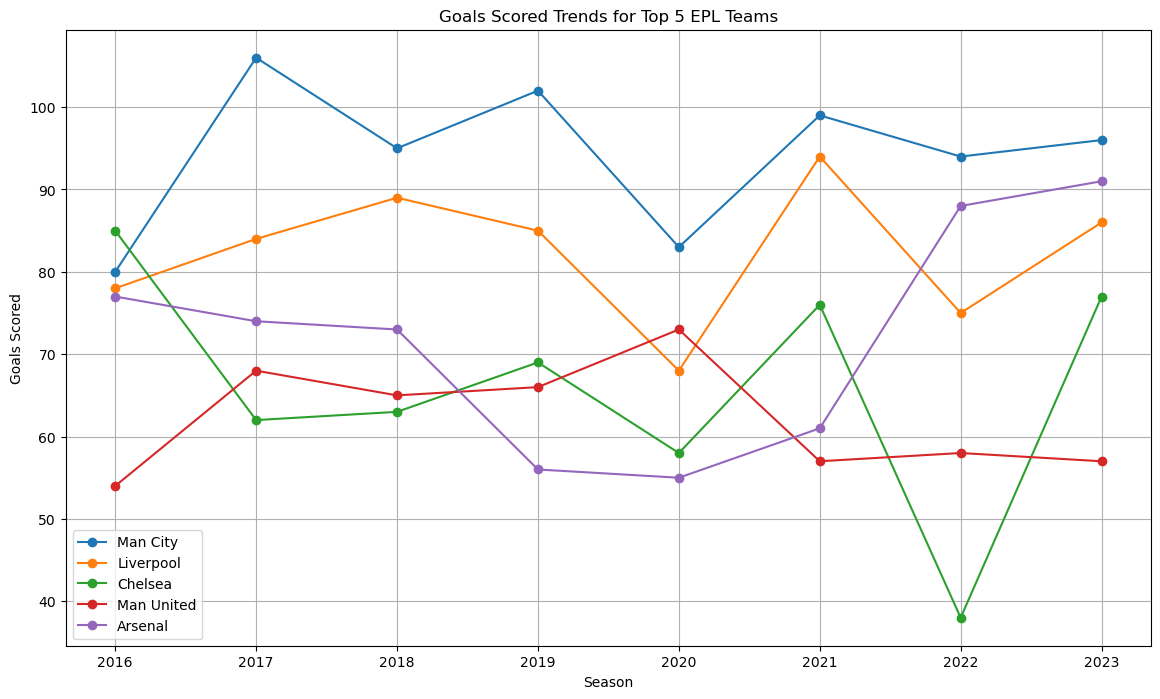

In [45]:
# Plot the goals scored trends for the top five teams
plt.figure(figsize=(14, 8))

for team in top_teams:
    team_data = top_teams_data[top_teams_data['Team'] == team]
    plt.plot(team_data['Season'], team_data['TotalGoalsScored'], marker='o', label=team)

plt.title('Goals Scored Trends for Top 5 EPL Teams')
plt.xlabel('Season')
plt.ylabel('Goals Scored')
plt.xticks(top_teams_data['Season'].unique())
plt.legend()
plt.grid(True)
plt.show()


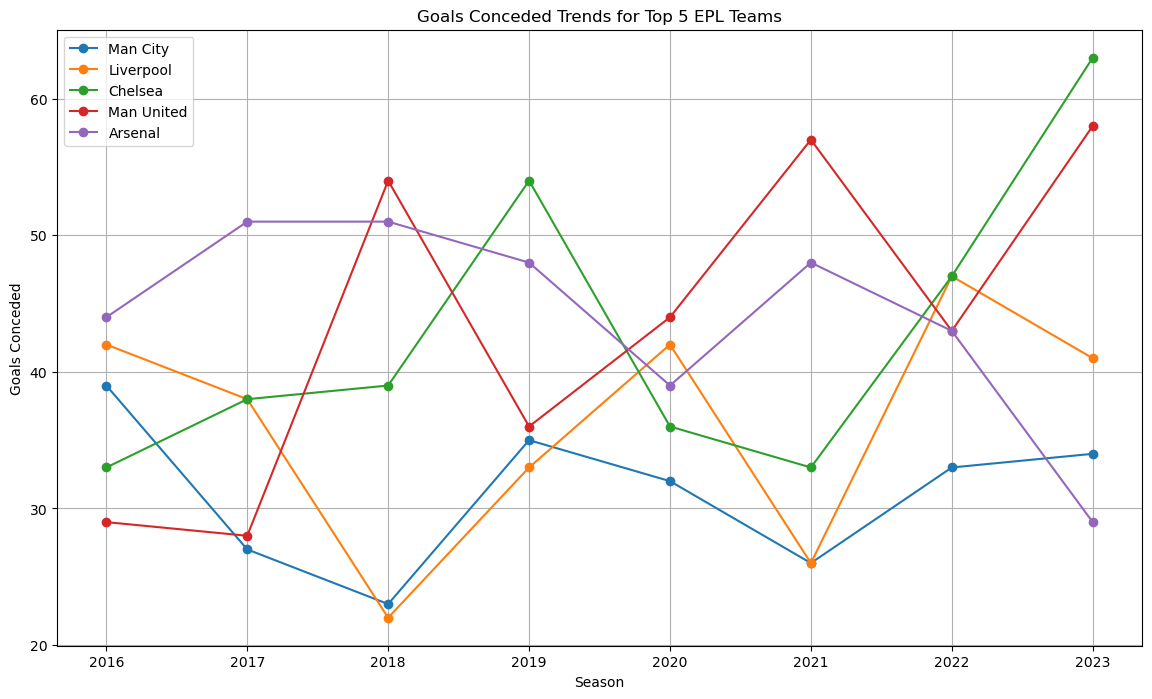

In [46]:
# Plot the goals conceded trends for the top five teams
plt.figure(figsize=(14, 8))

for team in top_teams:
    team_data = top_teams_data[top_teams_data['Team'] == team]
    plt.plot(team_data['Season'], team_data['TotalGoalsConceded'], marker='o', label=team)

plt.title('Goals Conceded Trends for Top 5 EPL Teams')
plt.xlabel('Season')
plt.ylabel('Goals Conceded')
plt.xticks(top_teams_data['Season'].unique())
plt.legend()
plt.grid(True)
plt.show()


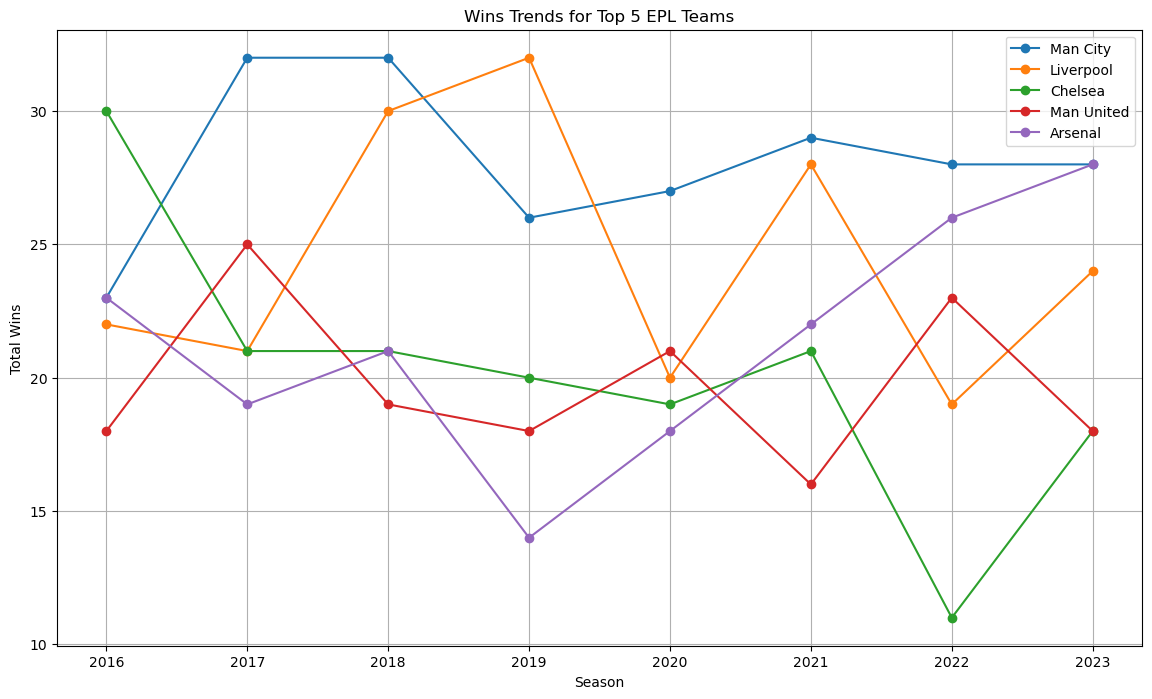

In [47]:
# Plot the wins trends for the top five teams
plt.figure(figsize=(14, 8))

for team in top_teams:
    team_data = top_teams_data[top_teams_data['Team'] == team]
    plt.plot(team_data['Season'], team_data['TotalWins'], marker='o', label=team)

plt.title('Wins Trends for Top 5 EPL Teams')
plt.xlabel('Season')
plt.ylabel('Total Wins')
plt.xticks(top_teams_data['Season'].unique())
plt.legend()
plt.grid(True)
plt.show()


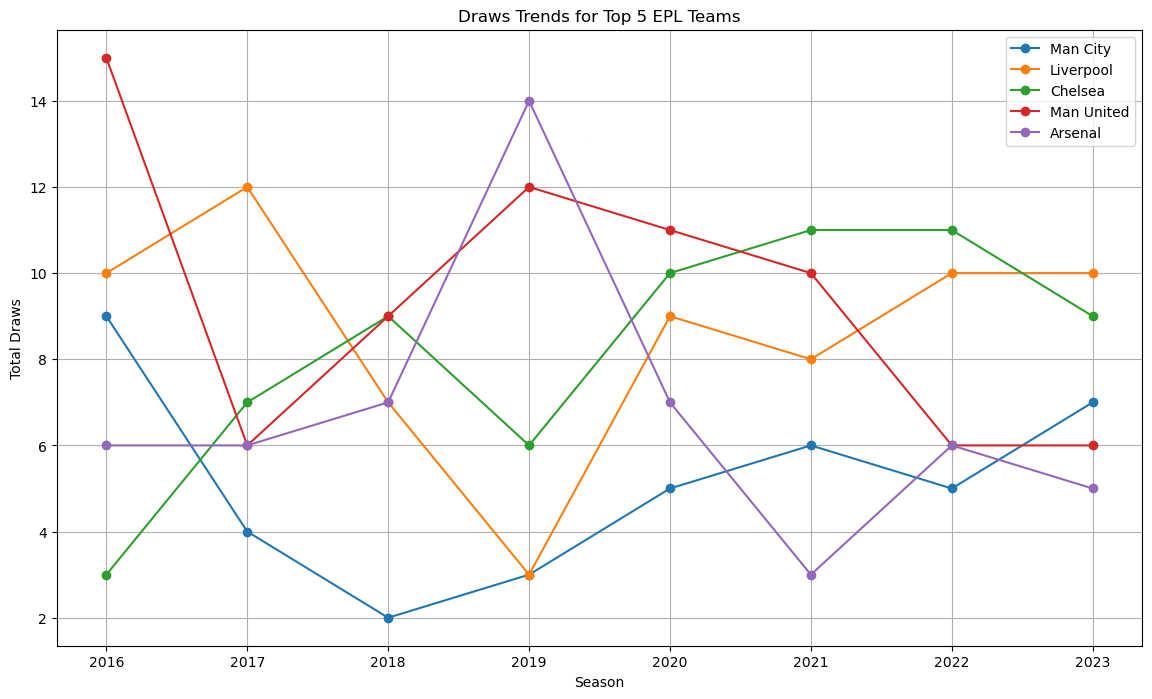

In [48]:
# Plot the draws trends for the top five teams
plt.figure(figsize=(14, 8))

for team in top_teams:
    team_data = top_teams_data[top_teams_data['Team'] == team]
    plt.plot(team_data['Season'], team_data['TotalDraws'], marker='o', label=team)

plt.title('Draws Trends for Top 5 EPL Teams')
plt.xlabel('Season')
plt.ylabel('Total Draws')
plt.xticks(top_teams_data['Season'].unique())
plt.legend()
plt.grid(True)
plt.show()


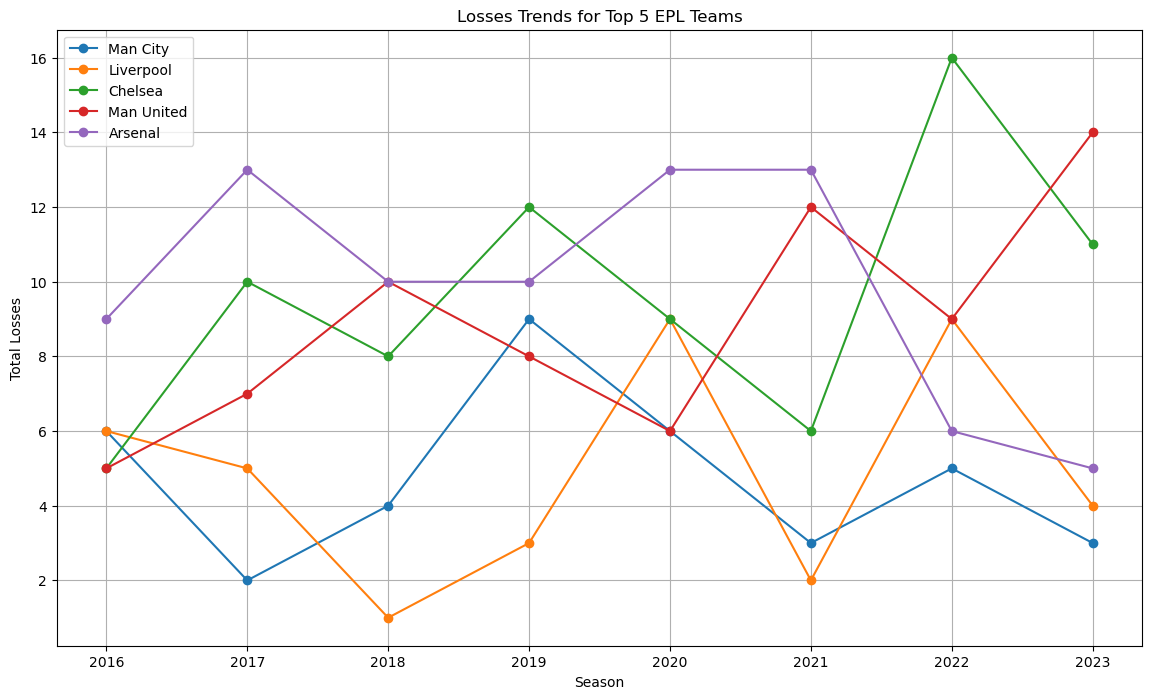

In [49]:
# Plot the losses trends for the top five teams
plt.figure(figsize=(14, 8))

for team in top_teams:
    team_data = top_teams_data[top_teams_data['Team'] == team]
    plt.plot(team_data['Season'], team_data['TotalLosses'], marker='o', label=team)

plt.title('Losses Trends for Top 5 EPL Teams')
plt.xlabel('Season')
plt.ylabel('Total Losses')
plt.xticks(top_teams_data['Season'].unique())
plt.legend()
plt.grid(True)
plt.show()

### Poisson Distribution Analysis

In [50]:
from scipy.stats import poisson

In [51]:
# Calculate the average goals scored per game for each of the top teams across all seasons
top_teams_goals = top_teams_data.groupby('Team').agg({
    'TotalGoalsScored': 'sum',
    'TotalGoalsConceded': 'sum',
    'TotalPoints': 'sum'
})
top_teams_goals['MatchesPlayed'] = top_teams_data.groupby('Team')['TotalGoalsScored'].count() * 38  # Each season has 38 matches
top_teams_goals['AvgGoalsScored'] = top_teams_goals['TotalGoalsScored'] / top_teams_goals['MatchesPlayed']
top_teams_goals['AvgGoalsConceded'] = top_teams_goals['TotalGoalsConceded'] / top_teams_goals['MatchesPlayed']


In [52]:
# Display the calculated average goals scored and conceded
print(top_teams_goals[['AvgGoalsScored', 'AvgGoalsConceded']])

            AvgGoalsScored  AvgGoalsConceded
Team                                        
Arsenal           1.891447          1.161184
Chelsea           1.736842          1.128289
Liverpool         2.167763          0.957237
Man City          2.483553          0.819079
Man United        1.638158          1.148026


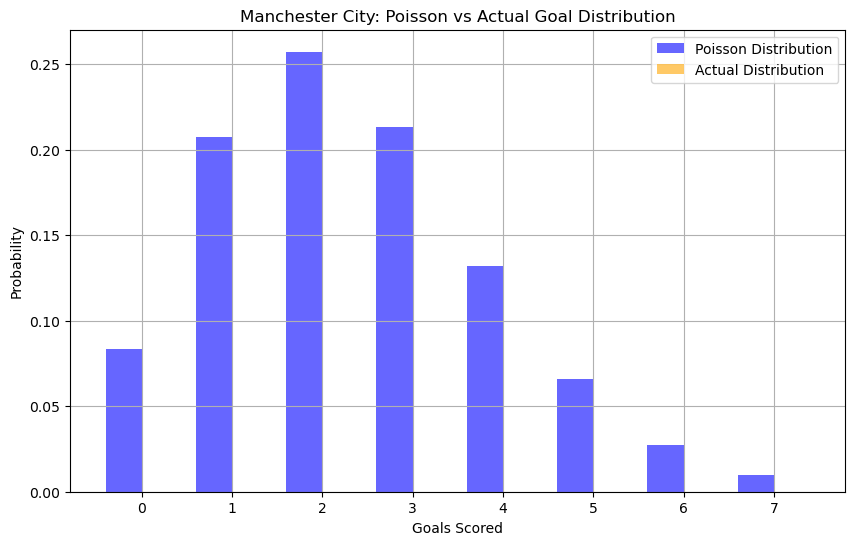

In [53]:
# Focus on Manchester City as an example
man_city_avg_goals = top_teams_goals.loc['Man City', 'AvgGoalsScored']

# Generate the Poisson distribution based on the average goals scored per match
goals_range = np.arange(0, 8)  # We'll consider the range of 0 to 7 goals
poisson_dist = poisson.pmf(goals_range, man_city_avg_goals)

# Get the actual distribution of goals scored by Manchester City across all seasons
man_city_goals = top_teams_data[top_teams_data['Team'] == 'Man City']['TotalGoalsScored']
actual_goals_distribution = man_city_goals.value_counts(normalize=True).reindex(goals_range, fill_value=0)

# Plot the Poisson distribution against the actual goal distribution
plt.figure(figsize=(10, 6))
plt.bar(goals_range - 0.2, poisson_dist, width=0.4, color='blue', alpha=0.6, label='Poisson Distribution')
plt.bar(goals_range + 0.2, actual_goals_distribution, width=0.4, color='orange', alpha=0.6, label='Actual Distribution')
plt.title('Manchester City: Poisson vs Actual Goal Distribution')
plt.xlabel('Goals Scored')
plt.ylabel('Probability')
plt.xticks(goals_range)
plt.legend()
plt.grid(True)
plt.show()

### DATA PREPERATION

In [54]:
# Splitting the dataset into training and testing sets

# Training on data from 2016-2023
train_data = seasons_combined[seasons_combined['Season'] < 2023]

# Testing on 2023-2024 season
test_data = seasons_combined[seasons_combined['Season'] == 2023]  

In [55]:
# Define features
features = [
    'Points_Home', 'GoalsScored_Home', 'GoalsConceded_Home',
    'Wins_Home', 'Draws_Home', 'Losses_Home',
    'Points_Away', 'GoalsScored_Away', 'GoalsConceded_Away',
    'Wins_Away', 'Draws_Away', 'Losses_Away'
]

In [56]:
# Create the 'Champion' and 'Top3' columns
train_data['Champion'] = train_data.groupby('Season')['TotalPoints'].transform(lambda x: x == x.max()).astype(int)
test_data['Champion'] = test_data.groupby('Season')['TotalPoints'].transform(lambda x: x == x.max()).astype(int)

/var/folders/xt/sr401pdn4bzgnrmb9jf3t4gw0000gn/T/ipykernel_35720/185848690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Champion'] = train_data.groupby('Season')['TotalPoints'].transform(lambda x: x == x.max()).astype(int)
/var/folders/xt/sr401pdn4bzgnrmb9jf3t4gw0000gn/T/ipykernel_35720/185848690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Champion'] = test_data.groupby('Season')['TotalPoints'].transform(lambda x: x == x.max()).astype(int)


In [57]:
train_data['Top3'] = train_data.groupby('Season')['TotalPoints'].rank(ascending=False, method='first') <= 4
train_data['Top3'] = train_data['Top3'].astype(int)

test_data['Top3'] = test_data.groupby('Season')['TotalPoints'].rank(ascending=False, method='first') <= 4
test_data['Top3'] = test_data['Top3'].astype(int)


/var/folders/xt/sr401pdn4bzgnrmb9jf3t4gw0000gn/T/ipykernel_35720/2232274139.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Top3'] = train_data.groupby('Season')['TotalPoints'].rank(ascending=False, method='first') <= 4
/var/folders/xt/sr401pdn4bzgnrmb9jf3t4gw0000gn/T/ipykernel_35720/2232274139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Top3'] = train_data['Top3'].astype(int)
/var/folders/xt/sr401pdn4bzgnrmb9jf3t4gw0000gn/T/ipykernel_35720/2232274139.py:4: SettingWithCop

In [58]:
# Define target variables
target_winner = 'Champion'
target_top3 = 'Top3'
target_points = 'TotalPoints'


In [59]:
# Extract features and target variables for training and testing
X_train = train_data[features]
y_train_winner = train_data[target_winner]
y_train_top3 = train_data[target_top3]
y_train_points = train_data[target_points]

X_test = test_data[features]
y_test_winner = test_data[target_winner]
y_test_top3 = test_data[target_top3]
y_test_points = test_data[target_points]


## MODEL TRAINING

### LOGISTIC REGRESSION

In [60]:
from sklearn.linear_model import LogisticRegression

# Train the Logistic Regression model for League Winner 
logreg_winner = LogisticRegression(max_iter=1000, random_state=42)
logreg_winner.fit(X_train, y_train_winner)

LogisticRegression(max_iter=1000, random_state=42)

In [61]:
logreg_top3 = LogisticRegression(max_iter=1000, random_state=42)
logreg_top3.fit(X_train, y_train_top3)

LogisticRegression(max_iter=1000, random_state=42)

In [62]:
# Logistic Regression
y_pred_winner_logreg = logreg_winner.predict(X_test)
print(y_pred_winner_logreg)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [63]:
# Logistic Regression
y_pred_top3_logreg = logreg_top3.predict(X_test)


In [64]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate accuracy and generate report for League Winner prediction using Logistic Regression
accuracy_winner_logreg = accuracy_score(y_test_winner, y_pred_winner_logreg)
report_winner_logreg = classification_report(y_test_winner, y_pred_winner_logreg)

In [65]:
print("Logistic Regression Accuracy for League Winner:", accuracy_winner_logreg)

Logistic Regression Accuracy for League Winner: 0.9


In [66]:
print("Classification Report:\n", report_winner_logreg)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.00      0.00      0.00         1

    accuracy                           0.90        20
   macro avg       0.47      0.47      0.47        20
weighted avg       0.90      0.90      0.90        20



In [67]:
# Evaluate accuracy and generate report for Top-4 prediction using Logistic Regression
accuracy_top3_logreg = accuracy_score(y_test_top3, y_pred_top3_logreg)
report_top3_logreg = classification_report(y_test_top3, y_pred_top3_logreg)

In [68]:
print("Logistic Regression Accuracy for Top-3 Prediction:", accuracy_top3_logreg)

Logistic Regression Accuracy for Top-3 Prediction: 0.95


In [69]:
print("Classification Report:\n", report_top3_logreg)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.75      0.86         4

    accuracy                           0.95        20
   macro avg       0.97      0.88      0.91        20
weighted avg       0.95      0.95      0.95        20



### XG BOOST

In [70]:
from xgboost import XGBClassifier, XGBRegressor

In [71]:
# Train the XGBoost model for League Winner 
xgb_winner = XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_winner.fit(X_train, y_train_winner)

/Users/pranavnigam/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:02:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [72]:
#Train for top3
xgb_top3 = XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_top3.fit(X_train, y_train_top3)

/Users/pranavnigam/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:02:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [73]:
# Train the XGBoost Regressor for Points prediction
xgb_points = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
xgb_points.fit(X_train, y_train_points)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [74]:
# XGBoost
y_pred_winner_xgb = xgb_winner.predict(X_test)
print(y_pred_winner_xgb)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [75]:
# XGBoost
y_pred_top3_xgb = xgb_top3.predict(X_test)


In [76]:
# Evaluate accuracy and generate report for League Winner prediction using XGBoost
accuracy_winner_xgb = accuracy_score(y_test_winner, y_pred_winner_xgb)
report_winner_xgb = classification_report(y_test_winner, y_pred_winner_xgb)

/Users/pranavnigam/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranavnigam/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranavnigam/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [77]:
print("XGBoost Accuracy for League Winner:", accuracy_winner_xgb)

XGBoost Accuracy for League Winner: 0.95


In [78]:
print("Classification Report:\n", report_winner_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       0.00      0.00      0.00         1

    accuracy                           0.95        20
   macro avg       0.47      0.50      0.49        20
weighted avg       0.90      0.95      0.93        20



In [79]:
# Evaluate accuracy and generate report for Top-4 prediction using XGBoost
accuracy_top3_xgb = accuracy_score(y_test_top3, y_pred_top3_xgb)
report_top3_xgb = classification_report(y_test_top3, y_pred_top3_xgb)

In [80]:
print("XGBoost Accuracy for Top-3 Prediction:", accuracy_top3_xgb)

XGBoost Accuracy for Top-3 Prediction: 0.95


In [81]:
print("Classification Report:\n", report_top3_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.75      0.86         4

    accuracy                           0.95        20
   macro avg       0.97      0.88      0.91        20
weighted avg       0.95      0.95      0.95        20



### RANDOM FOREST CLASSIFIER

In [82]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model for League Winner
rf_winner = RandomForestClassifier(n_estimators=100, random_state=42)
rf_winner.fit(X_train, y_train_winner)


RandomForestClassifier(random_state=42)

In [83]:
#Training for Top3 Prediction
rf_top3 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top3.fit(X_train, y_train_top3)


RandomForestClassifier(random_state=42)

In [84]:
# Random Forest
y_pred_winner_rf = rf_winner.predict(X_test)
print(y_pred_winner_rf)

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


In [85]:
# Random Forest
y_pred_top3_rf = rf_top3.predict(X_test)


In [86]:
# Evaluate accuracy and generate report for Top-4 prediction using Random Forest
accuracy_top3_rf = accuracy_score(y_test_top3, y_pred_top3_rf)
report_top3_rf = classification_report(y_test_top3, y_pred_top3_rf)


In [87]:
print("Random Forest Accuracy for Top-3 Prediction:", accuracy_top3_rf)

Random Forest Accuracy for Top-3 Prediction: 0.95


In [88]:
print("Classification Report:\n", report_top3_rf)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.75      0.86         4

    accuracy                           0.95        20
   macro avg       0.97      0.88      0.91        20
weighted avg       0.95      0.95      0.95        20



## LEAGUE WINNER PREDICTION

In [89]:
# Predict the league winner using Random Forest
y_pred_winner_rf = rf_winner.predict(X_test)

# Identify the team predicted to win the league (where 'Champion' == 1)
predicted_winner_team_rf = test_data.loc[y_pred_winner_rf == 1, 'Team'].values

In [90]:
# Output the predicted winner's team name
print("Predicted Winner using Random Forest:", predicted_winner_team_rf)

Predicted Winner using Random Forest: ['Man City']


## TOP-3 FINISH PREDICTION

In [91]:
# Predict the top 3 finishers using Logistic Regression
y_pred_top3_logreg = logreg_top3.predict(X_test)

# Identify the teams predicted to finish in the top four (where 'Top4' == 1)
predicted_top3_teams_logreg = test_data.loc[y_pred_top3_logreg == 1, 'Team'].values


In [92]:
# Output the predicted top 3 teams
print("Predicted Top-3 Teams using Logistic Regression:", predicted_top3_teams_logreg)

Predicted Top-3 Teams using Logistic Regression: ['Arsenal' 'Liverpool' 'Man City']


In [93]:
# Predict the top 3 finishers using XGBoost
y_pred_top3_xgb = xgb_top3.predict(X_test)

# Identify the teams predicted to finish in the top 3(where 'Top4' == 1)
predicted_top3_teams_xgb = test_data.loc[y_pred_top3_xgb == 1, 'Team'].values


In [94]:
# Output the predicted top four teams
print("Predicted Top-3 Teams using XGBoost:", predicted_top3_teams_xgb)

Predicted Top-3 Teams using XGBoost: ['Arsenal' 'Liverpool' 'Man City']


In [95]:
# Predict the top 3 finishers using Random Forest
y_pred_top3_rf = rf_top3.predict(X_test)

# Identify the teams predicted to finish in the top four (where 'Top4' == 1)
predicted_top3_teams_rf = test_data.loc[y_pred_top3_rf == 1, 'Team'].values


In [96]:
# Output the predicted top four teams
print("Predicted Top-3 Teams using Random Forest:", predicted_top3_teams_rf)

Predicted Top-3 Teams using Random Forest: ['Arsenal' 'Liverpool' 'Man City']


## POINTS TABLE PREDICTION

In [97]:
from sklearn.ensemble import RandomForestRegressor

In [98]:
# Initialize the RandomForestRegressor
rf_model_points = RandomForestRegressor(random_state=42)

# Train the model on the training data
rf_model_points.fit(X_train, y_train_points)

# Make predictions on the test data
y_pred_points_rf = rf_model_points.predict(X_test)

# Combine predictions with the team names for display
predicted_points_rf_df = pd.DataFrame({
    'Team': test_data['Team'],
    'Predicted Points': y_pred_points_rf
}) 


In [99]:
# Display the predicted points for each team, sorted by points
predicted_points_rf_df = predicted_points_rf_df.sort_values(by='Predicted Points', ascending=False)

In [112]:
print(predicted_points_rf_df.head(10))

               Team  Predicted Points
152        Man City             89.72
140         Arsenal             89.14
150       Liverpool             81.68
141     Aston Villa             71.29
157       Tottenham             64.72
146         Chelsea             63.71
154       Newcastle             59.95
153      Man United             59.09
158        West Ham             53.36
147  Crystal Palace             48.00


In [101]:
# Save the DataFrame to a CSV file
predicted_points_rf_df.to_csv('predicted_points_rf.csv', index=False)


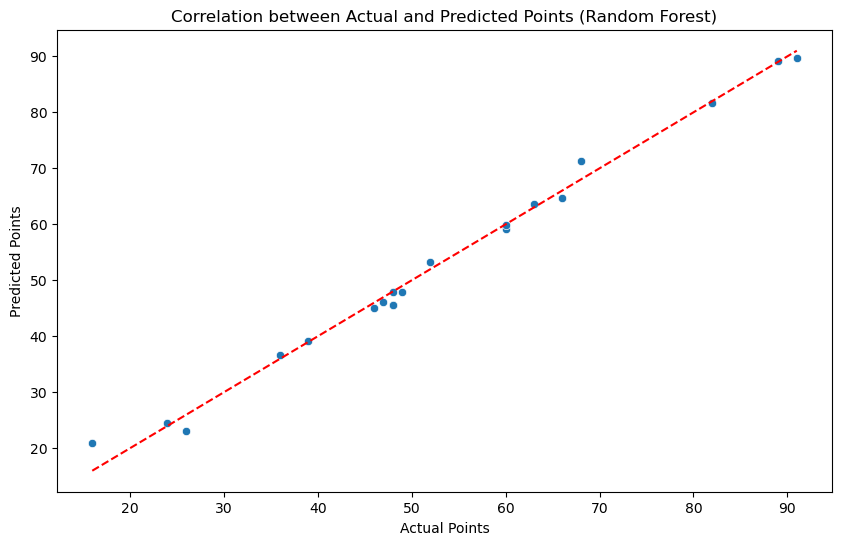

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot to visualize the correlation between actual and predicted points
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_points, y=y_pred_points_rf)
plt.plot([min(y_test_points), max(y_test_points)], [min(y_test_points), max(y_test_points)], color='red', linestyle='--')  # Diagonal line for reference
plt.title('Correlation between Actual and Predicted Points (Random Forest)')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.show()



In [103]:
import numpy as np

In [104]:
# 1. Feature Importance from Logistic Regression (using coefficients)
logreg_importance = np.abs(logreg_winner.coef_[0])
logreg_importance = logreg_importance / np.sum(logreg_importance)  # Normalize
logreg_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance_LogReg': logreg_importance})


In [105]:
# 2. Feature Importance from XGBoost
xgb_importance = xgb_winner.feature_importances_
xgb_importance = xgb_importance / np.sum(xgb_importance)  # Normalize
xgb_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance_XGB': xgb_importance})


In [106]:
# 3. Feature Importance from Random Forest
rf_importance = rf_winner.feature_importances_
rf_importance = rf_importance / np.sum(rf_importance)  # Normalize
rf_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance_RF': rf_importance})


In [107]:
# Combine all importance dataframes
importance_df = logreg_importance_df.merge(xgb_importance_df, on='Feature').merge(rf_importance_df, on='Feature')


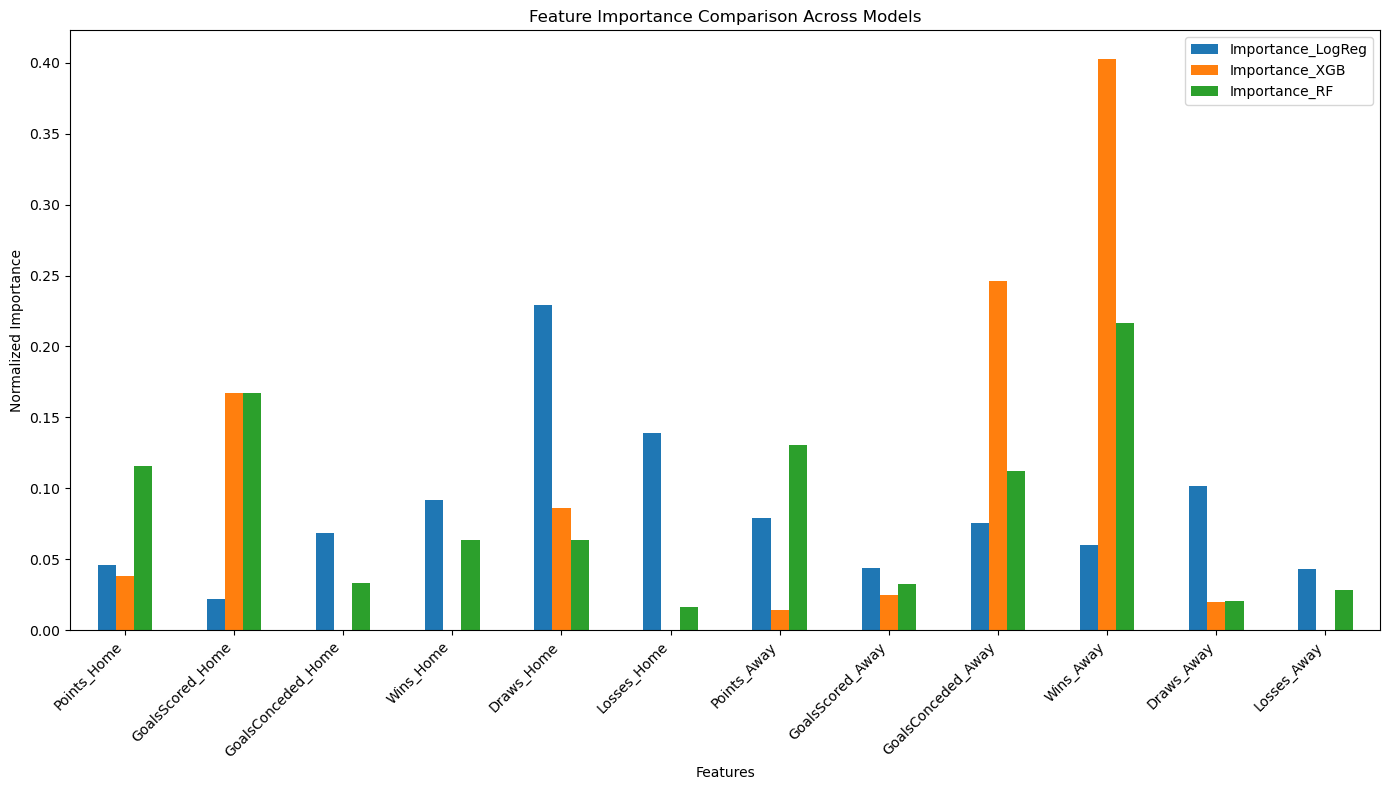

In [108]:
# Plotting the feature importance comparison
importance_df.set_index('Feature', inplace=True)
importance_df.plot(kind='bar', figsize=(14, 8))
plt.title('Feature Importance Comparison Across Models')
plt.ylabel('Normalized Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()